# Dependencies and files

## Install dependencies

## Imports

In [1]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

import time
from tqdm.notebook import tqdm
import requests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [2]:
de_dir_path = '../../data/DE/ANOVA_mean/'

In [3]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [4]:
os.listdir(de_dir_path)

['anova_mamm_mean.csv',
 'cluster_spectr_anova_mean_6.csv',
 'cluster_spectr_anova_mean_7.csv',
 'cluster_spectr_anova_mean_8.csv',
 'cluster_spectr_anova_mean_9.csv',
 'ttest_mamm_mean.csv']

## Load files

### DE results

In [5]:
anova_res = pd.read_csv(de_dir_path + 'anova_mamm_mean.csv', index_col=0)
anova_genes = anova_res[anova_res.p_val_adj < 0.05].index
anova_res.head()

sum_sq    df         F    PR(>F)  p_val_adj
A1BG   0.122578  12.0  2.796490  0.003701   0.010364
AAAS   0.017527  12.0  0.944161  0.509517   0.596369
AACS   0.136394  12.0  2.729393  0.004508   0.012212
AADAT  0.057031  12.0  5.478881  0.000002   0.000016
AAGAB  0.043359  12.0  2.127609  0.026045   0.053640

In [6]:
n_clusters = 7
anova_labels = pd.read_csv(de_dir_path + f'cluster_spectr_anova_mean_{n_clusters}.csv', index_col=0)['0'].sort_values()
anova_labels = anova_labels
anova_labels.name = 'ANOVA_labels'

## Load normalized pseudobulks

In [7]:
pb_dir_path = '../../data/pseudobulks/'

In [8]:
os.listdir(pb_dir_path)

['4spe_pb_mean_filt.h5ad',
 '4spe_pb_mean_filt_nor_mean.h5ad',
 'pb_age.h5ad',
 'pb_mammals.h5ad',
 'pb_mammals_filtered.h5ad',
 'pb_mammals_samplenorm_mean.h5ad',
 'pb_mammals_samplenorm_zscore.h5ad']

In [9]:
adata_pb_norm = sc.read_h5ad(pb_dir_path + 'pb_mammals_samplenorm_mean.h5ad')
#adata_pb_norm_mean.var = anova_res
adata_pb_norm

AnnData object with n_obs × n_vars = 89 × 9208
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props'

In [10]:
background_genes = adata_pb_norm.var_names.tolist()
len(background_genes)

9208

## Specie-specific genes

In [11]:
import pickle
with open("./results/specie_specific_genes_tr50.pkl", "rb") as file:
    genes_dict77 = pickle.load(file)

## Helpful functions

In [12]:
def p_val_group(value):
    if value >= 0.05:
        return 'No significance'
    elif  0.01 <= value < 0.05:
        return 'p < 0.05'
    elif  0.001 <= value < 0.01:
        return 'p < 0.01'
    else:
        return 'p < 0.001'

In [13]:
color_discrete_map = {'No significance': 'darkblue',
                      'p < 0.05': 'purple',
                      'p < 0.01': 'darkorange',
                      'p < 0.001': 'yellow'}

In [14]:
class GeneCluster:
    def __init__(self, genes, descr, label, background_genes, **kwargs):
        self.label = label
        self.genes = genes
        self.descr = descr
        self.background_genes = background_genes
        self.userlist_id = self._get_userlist_id()
        self.background_id = self._get_background_id()
        self.enrichment_res = dict()

    
    def _get_userlist_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        description = "sample gene set with background"

        res = requests.post(
            base_url+'/api/addList',
            files=dict(
              list=(None, '\n'.join(self.genes)),
              description=(None, description),
            )
          )
        if res.ok:
            userlist_response = res.json()
        return userlist_response['userListId']
    
    def _get_background_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
            base_url+'/api/addbackground',
            data=dict(background='\n'.join(self.background_genes))
        )

        if res.ok:
            background_response = res.json()
        return background_response['backgroundid']

    def enrich(self, gene_set_library):
        # get enrichment results
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
                base_url+'/api/backgroundenrich',
                data=dict(
                userListId=self.userlist_id,
                backgroundid=self.background_id,
                backgroundType=gene_set_library,
                )
            )
        if res.ok:
            data = res.json()
        # convert results to df
        columns = ['Rank', 'Term', 'p-val', 'Z-score', 'Combined score', 'Overlapping genes', 'Adjusted P-value', 'Old p-value', 'Old adjusted p-value']
        results = pd.DataFrame(data[gene_set_library], columns=columns)
        # preprocess df
        results.Term = results.Term.astype(str)
        results['num_overlap_genes'] = results['Overlapping genes'].apply(lambda x: len(x))
        results['neg_log10(p_adj)'] = - np.log10(results['Adjusted P-value'])
        results['cluster_label'] = self.label
        # save to enrichment_res
        self.enrichment_res[gene_set_library] = results

    @staticmethod
    def enrich_geneclusters(geneclusters, gene_set_library):
        for gc in geneclusters:
            gc.enrich(gene_set_library)

# Clusterisation

In [15]:
df = pd.DataFrame(adata_pb_norm.X, index=adata_pb_norm.obs_names, columns=adata_pb_norm.var_names)

In [16]:
hs_genes = genes_dict77['human']

In [17]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque']:
    samples = df.loc[df.index.str.contains(cond)].index
    order = sorted(samples.tolist(), key=lambda x: x[-2:])
    order_laminar = list(filter(lambda x: 'L' in x, order))
    order_wm = list(filter(lambda x: 'WM' in x, order))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque']
df = df.loc[sample_order['all']]
df_hs = df[hs_genes]

## Hierarchial

D:\Projects\spatialMPFC\venv\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


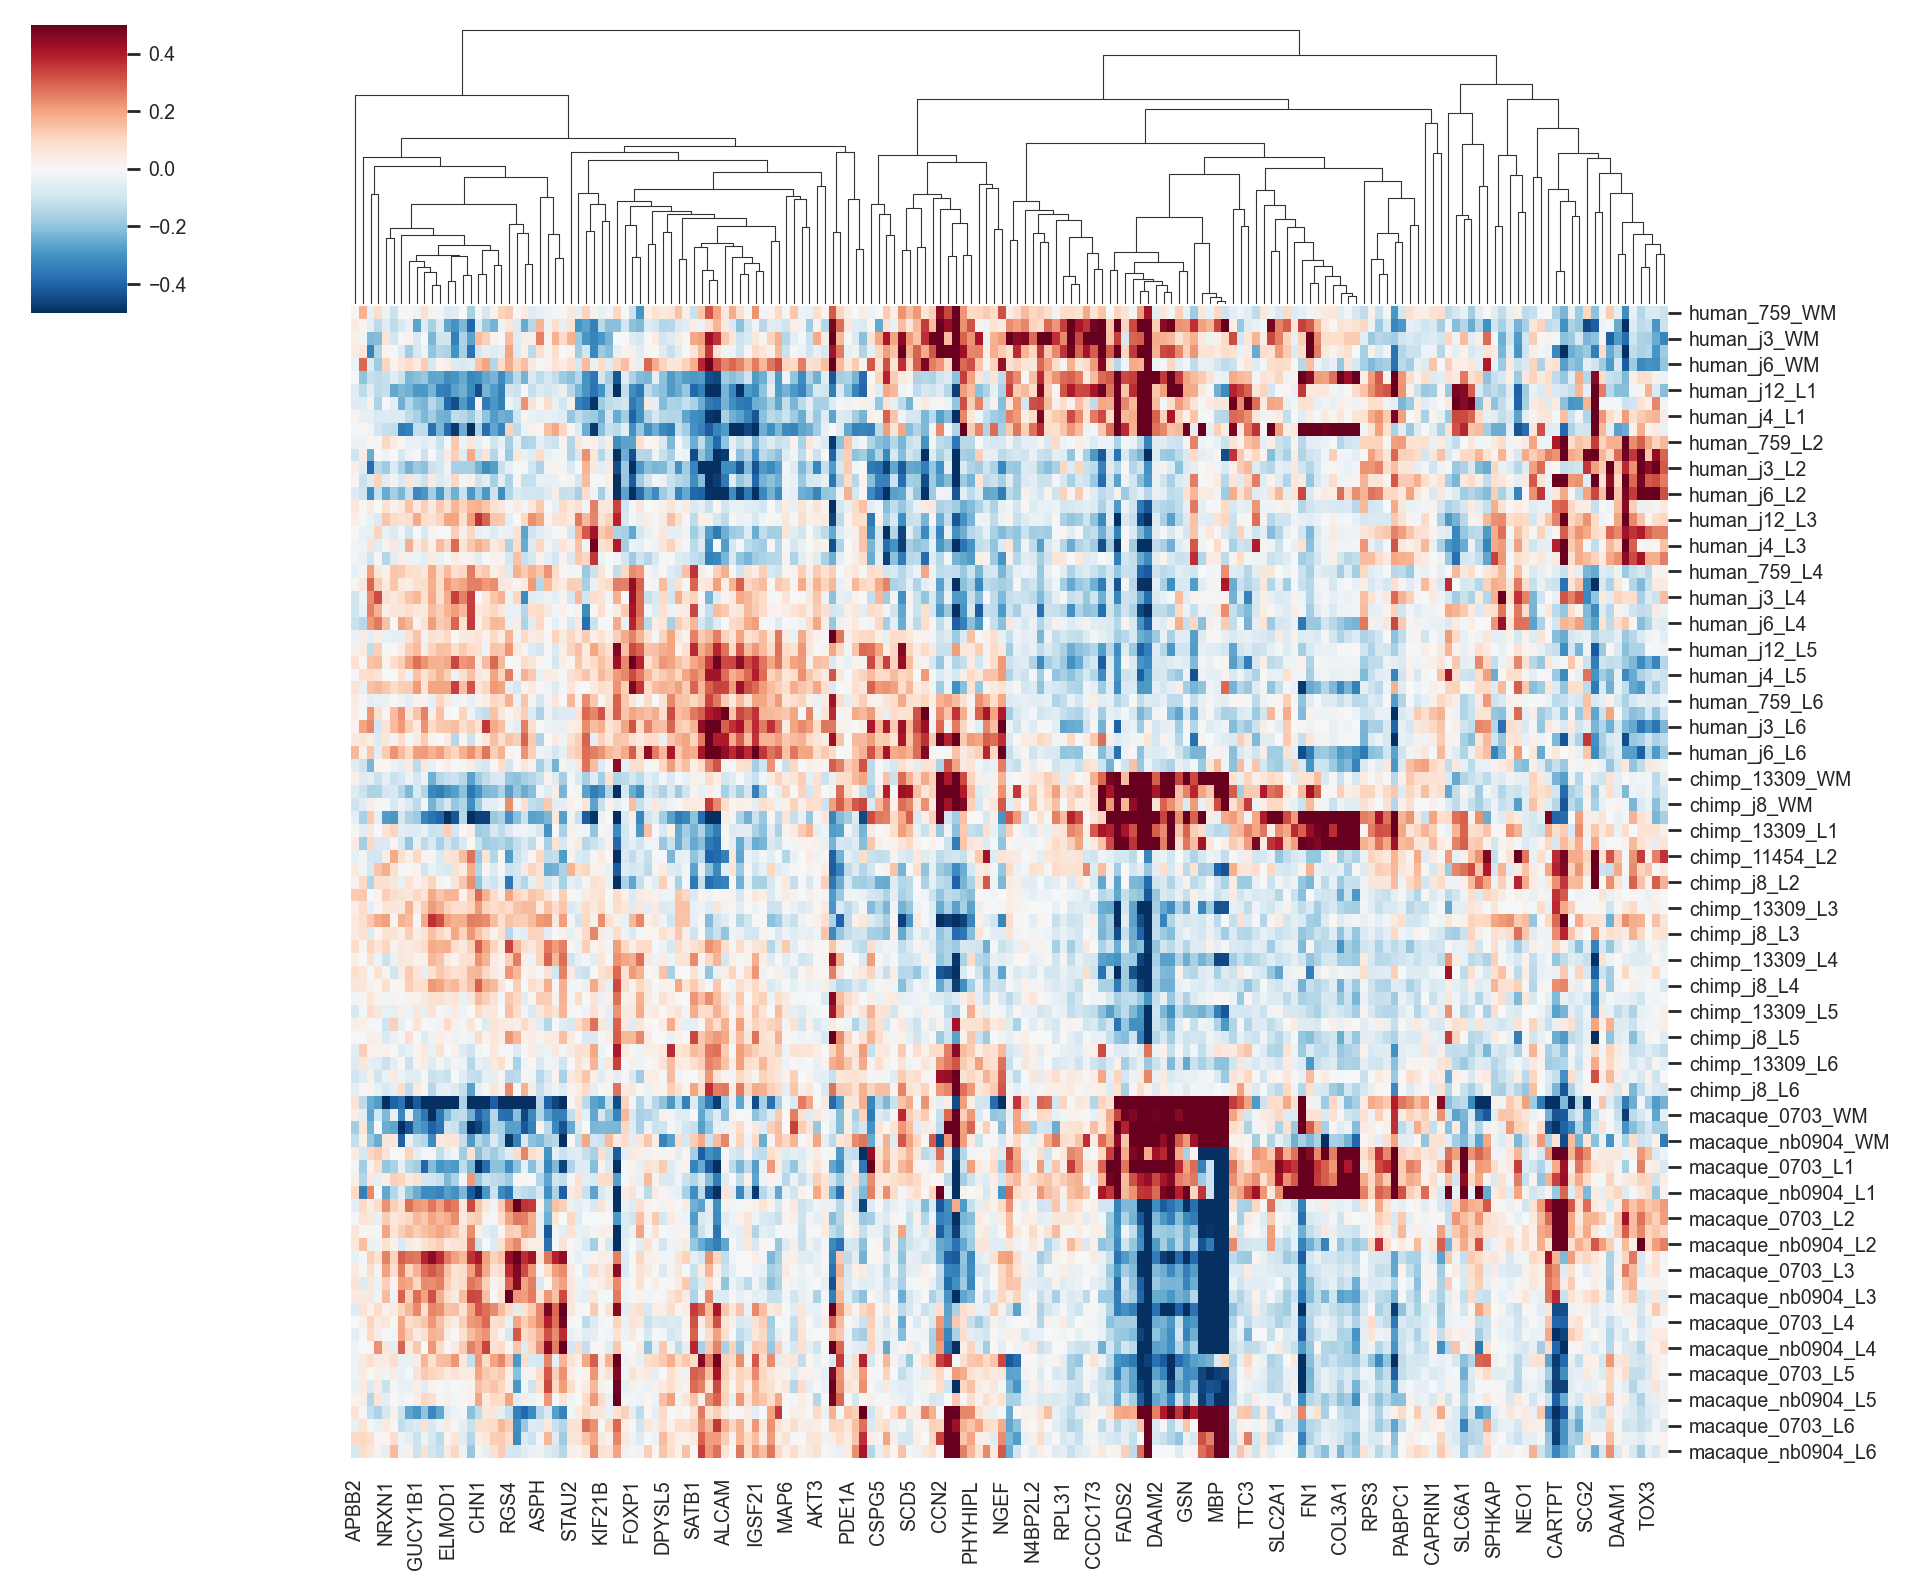

In [18]:
sns.set(font_scale=0.8)
sns.clustermap(df_hs, figsize=(12, 10), cmap="RdBu_r", center=0, vmax=0.5, vmin=-0.5, metric='cosine', annot_kws={"size": 2}, row_cluster=False)

## Spectral clusterisation

In [70]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import pairwise_kernels
#aff_matrix = pairwise_kernels(df_hs.T, metric='linear')
n_clusters = 6
clustering = SpectralClustering(n_clusters=n_clusters, gamma=1, affinity='nearest_neighbors', random_state=4)
clustering.fit(df_hs.T)

SpectralClustering(affinity='nearest_neighbors', gamma=1, n_clusters=6,
                   random_state=4)

In [71]:
labels = pd.Series(clustering.labels_, index=hs_genes).sort_values()
order = labels.sort_values().index

In [72]:
labels.to_csv('./results/human_clusters_50.csv')

In [73]:
cluster_color = ['red', 'yellow', 'orange', 'green', 'purple', 'blue', 'olive', 'pink', 'brown']

In [74]:
colors = cluster_color[:n_clusters]
clusters = np.arange(n_clusters)

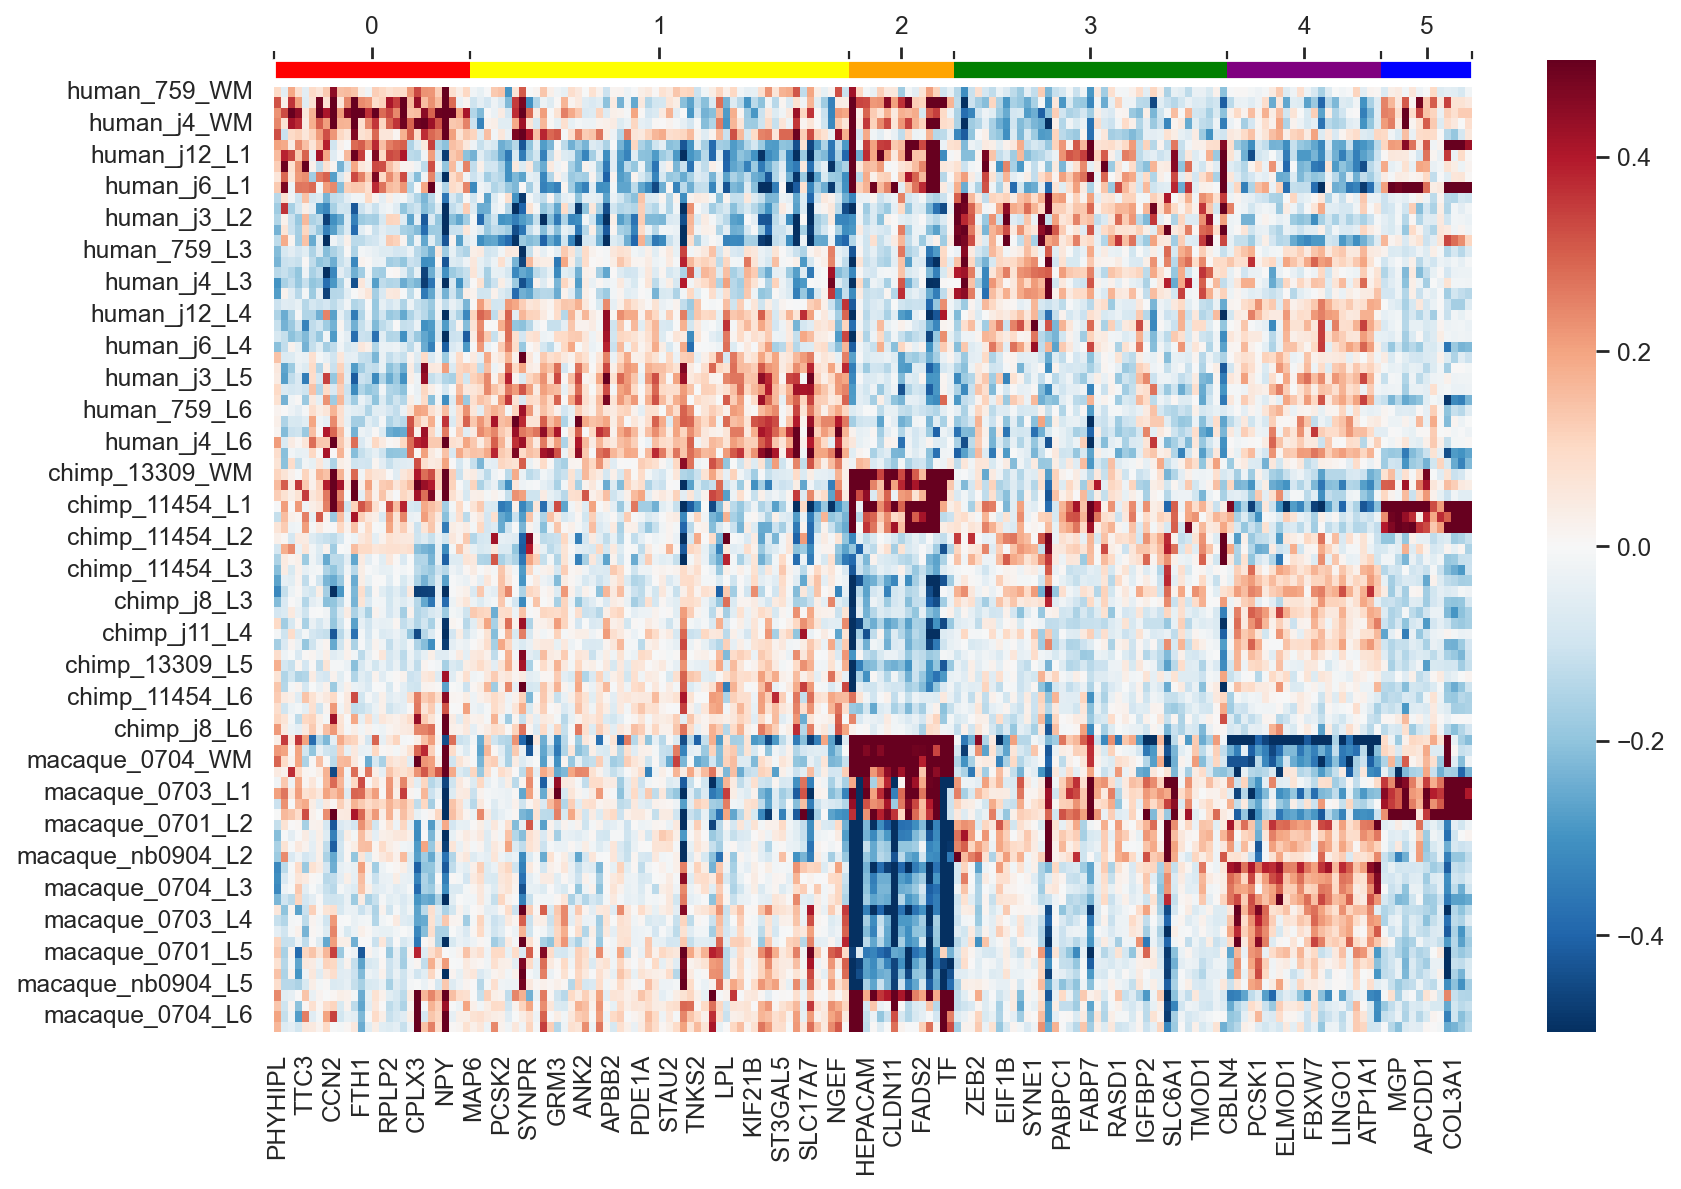

In [75]:
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df_hs[order], ax=ax, cmap="RdBu_r", vmax=0.5, vmin=-0.5, center=0)
divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = mpl.colors.ListedColormap(colors)

cluster_size = labels.value_counts().loc[clusters].values
cluster_pos = cluster_size.cumsum()
bounds = [0] + list(cluster_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(cluster_pos - cluster_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(clusters))
cax.xaxis.tick_top()

In [76]:
labels[labels == 1].size

54

## Cluster profiles (mean)

In [77]:
df_annotation = df_hs.copy()
df_annotation['layer'] = adata_pb_norm.obs.layer
df_annotation['condition'] = adata_pb_norm.obs.condition

In [78]:
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()

ACTA2      ADI1      AKT3     ALCAM      ANK2     APBB2  \
condition layer                                                               
chimp     L1     0.728220  0.232106 -0.012988  0.009130 -0.074303  0.000521   
          L2    -0.127487 -0.029761 -0.013202 -0.242804 -0.107423  0.009758   
          L3    -0.095616 -0.081698  0.004795 -0.066325 -0.046509  0.064595   
          L4    -0.111591 -0.069586 -0.005160  0.006249 -0.037624  0.065062   
          L5    -0.077636 -0.055009 -0.032334  0.134409 -0.015614 -0.020785   

                   APCDD1     APLP2       APP      AQP4  ...      TSPO  \
condition layer                                          ...             
chimp     L1     0.438053 -0.006447 -0.143722  0.764710  ...  0.040045   
          L2    -0.015450 -0.034986 -0.104327 -0.096835  ... -0.052895   
          L3    -0.180579 -0.042810  0.091190 -0.409157  ... -0.039607   
          L4    -0.162720 -0.058964  0.091682 -0.409665  ... -0.063044   
          L5    -0.139614  0.015875  0.062882 -0.282063  ... -0.015141   

                     TTC3     TTYH1    TUBA4A     UBAP2     VAT1L    VSTM2A  \
condition layer                                                               
chimp     L1     0.146501  0.071092 -0.190006  0.001697 -0.134595  0.077321   
          L2    -0.025527  0.014022 -0.271730  0.053347 -0.027984  0.210841   
          L3    -0.097487  0.005924 -0.212395 -0.041216 -0.090556  0.094489   
          L4    -0.118147 -0.032925  0.030377  0.017843 -0.019777  0.014245   
          L5    -0.079551 -0.050280  0.149852 -0.056467  0.138460 -0.087230   

                   ZBTB18      ZEB2    ZMYND8  
condition layer                                
chimp     L1    -0.154330  0.037896 -0.001521  
          L2     0.229193  0.051170  0.059591  
          L3     0.178206 -0.040480  0.063579  
          L4     0.129230 -0.075607  0.019230  
          L5     0.023022 -0.057856 -0.050828  

[5 rows x 171 columns]

Text(0.5, 0.98, 'Mean everaging for profiles')

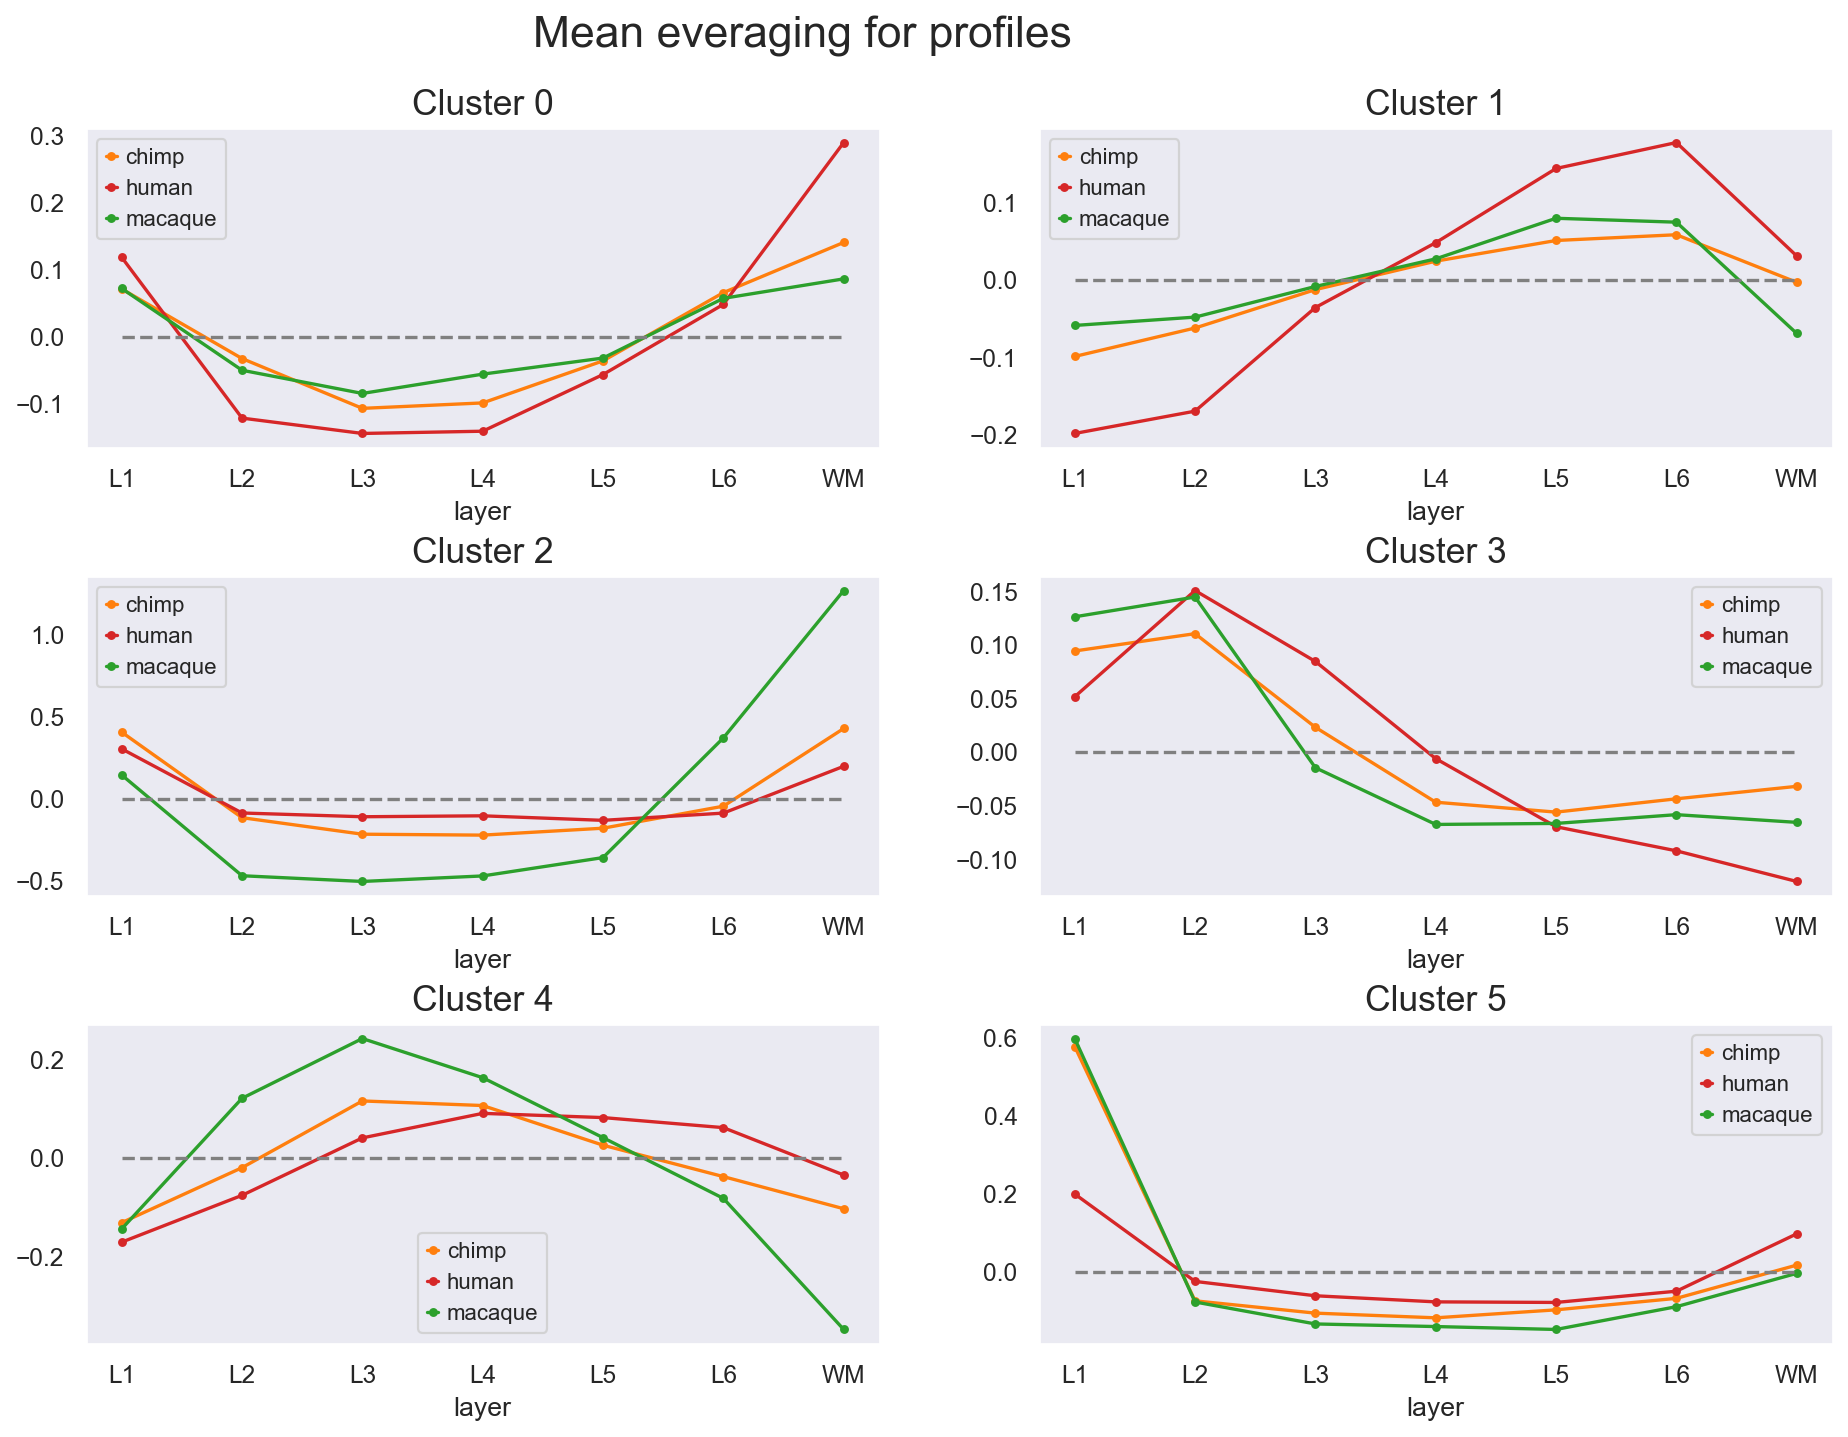

In [79]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.tolist()

    (
        layer_mean[genes]
        .mean(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

fig.suptitle('Mean everaging for profiles', fontsize=20)

## Cluster profiles (Median)

Text(0.5, 0.98, 'Median everaging for profiles')

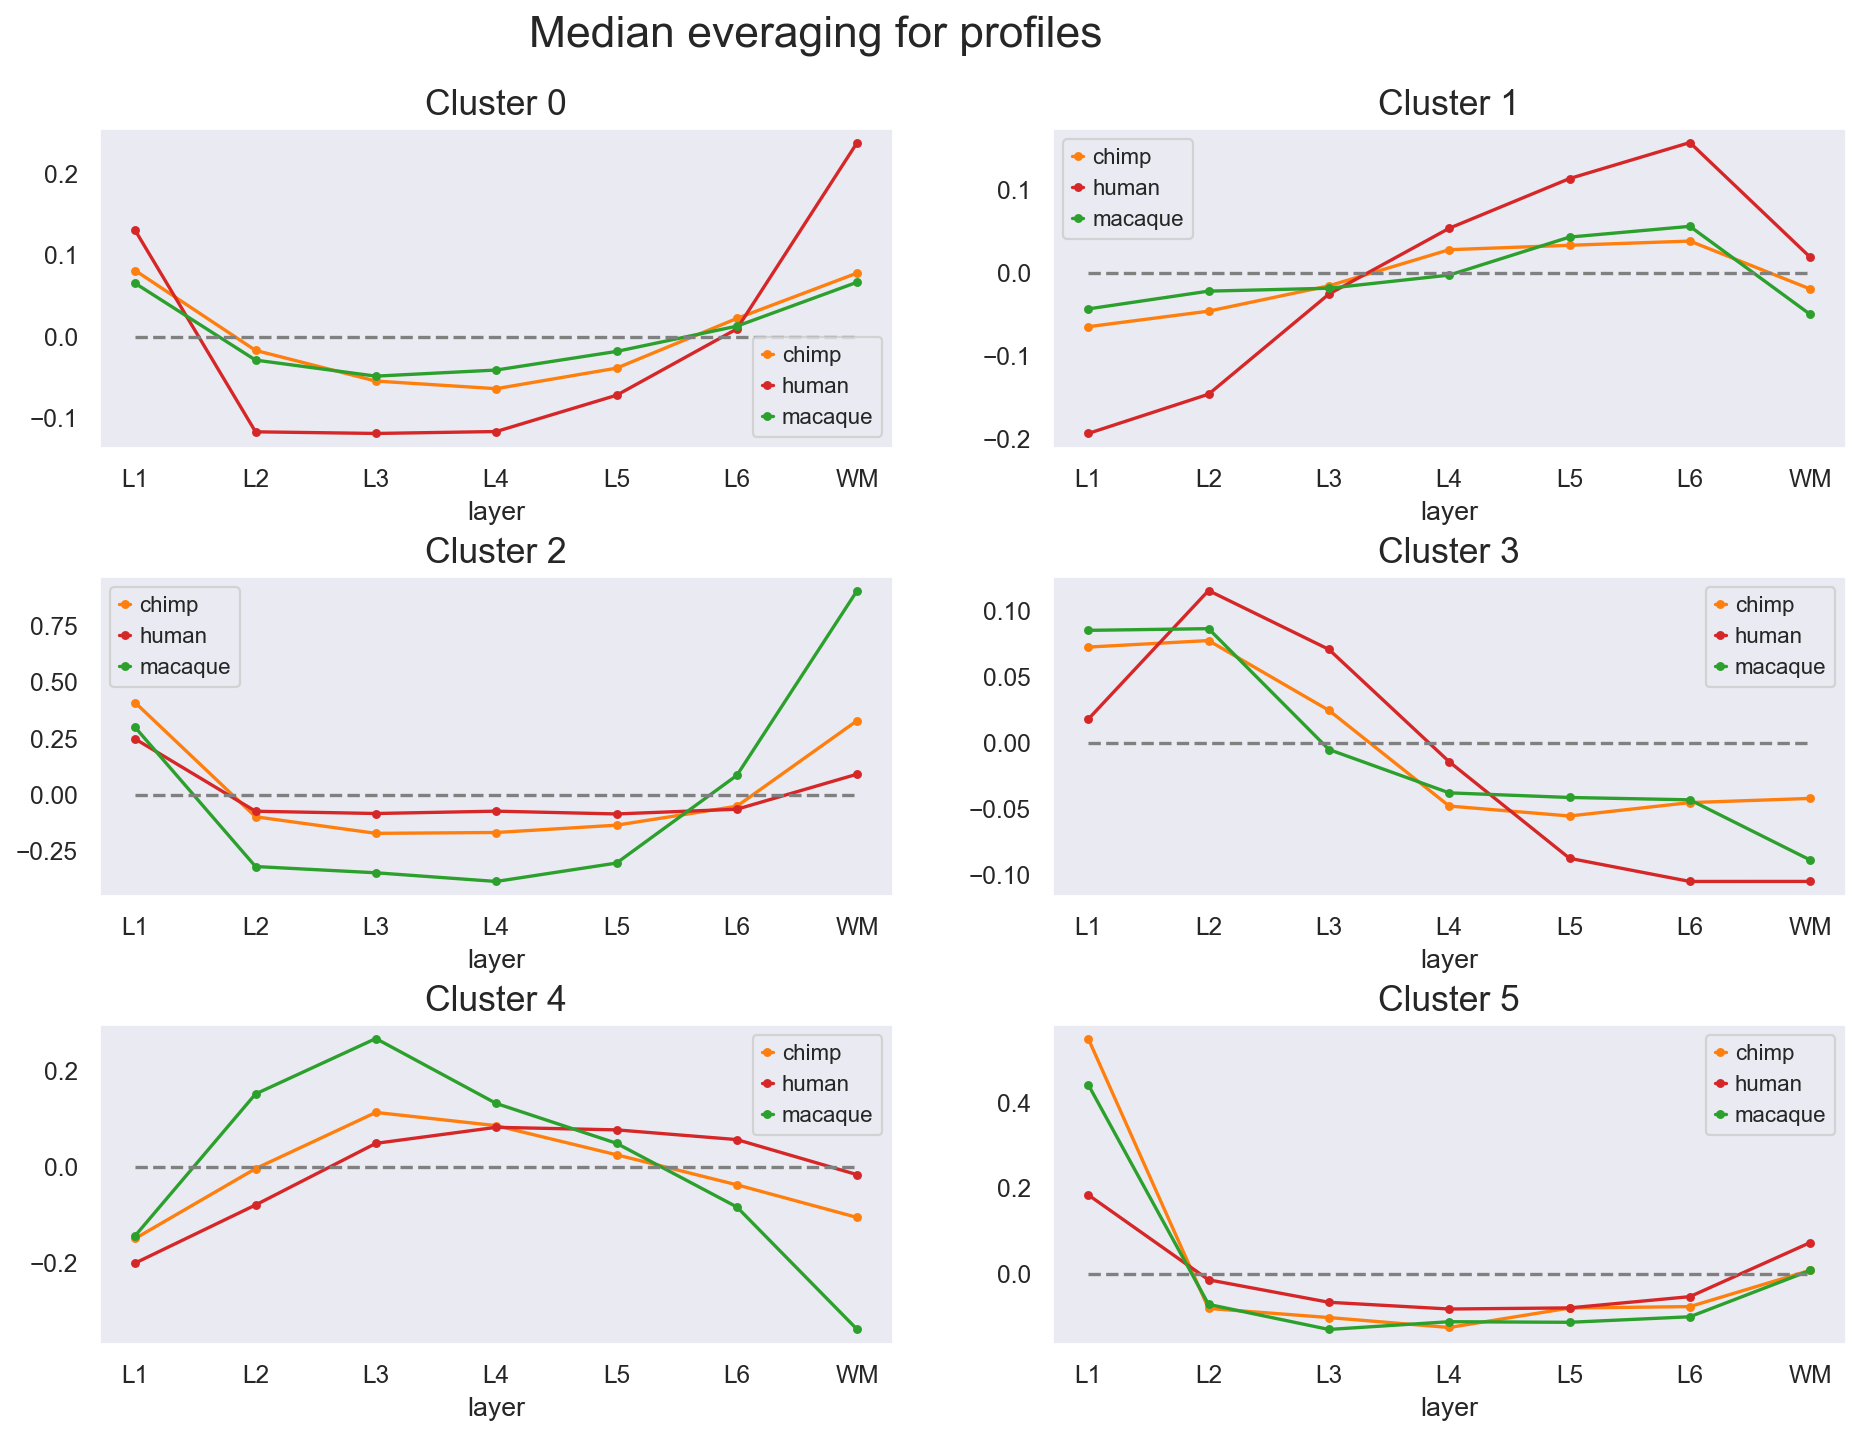

In [80]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.tolist()

    (
        layer_mean[genes]
        .median(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

fig.suptitle('Median everaging for profiles', fontsize=20)

# 4 Species

In [81]:
pb_dir_path = '../../data/pseudobulks/'
adata_pb_4spe = sc.read_h5ad(pb_dir_path + '4spe_pb_mean_filt_nor_mean.h5ad')
#adata_pb_4spe = sc.read_h5ad('results/adata_4spe.h5ad')
#adata_pb_norm_mean.var = anova_res
adata_pb_4spe

AnnData object with n_obs × n_vars = 116 × 6523
    obs: 'layer', 'sample_id', 'condition', 'lib_size', 'log_lib_size'
    var: 'gene_name'
    uns: 'log1p'

In [82]:
df_4spe = pd.DataFrame(adata_pb_4spe.X, index=adata_pb_4spe.obs_names, columns=adata_pb_4spe.var_names)

In [83]:
hs_genes_inter = df_4spe.columns.intersection(hs_genes)
hs_genes_inter.size

115

In [84]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque', 'treeshrew']:
    samples = df_4spe.loc[df_4spe.index.str.contains(cond)].index
    order_s = sorted(samples.tolist(), key=lambda x: x[:2])
    order_laminar = list(filter(lambda x: 'L' in x, order_s))
    order_wm = list(filter(lambda x: 'WM' in x, order_s))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque'] + sample_order['treeshrew']
df_4spe = df_4spe.loc[sample_order['all']]
df_4spe_hs = df_4spe[hs_genes_inter]

In [85]:
order_4spe = order.intersection(hs_genes_inter)

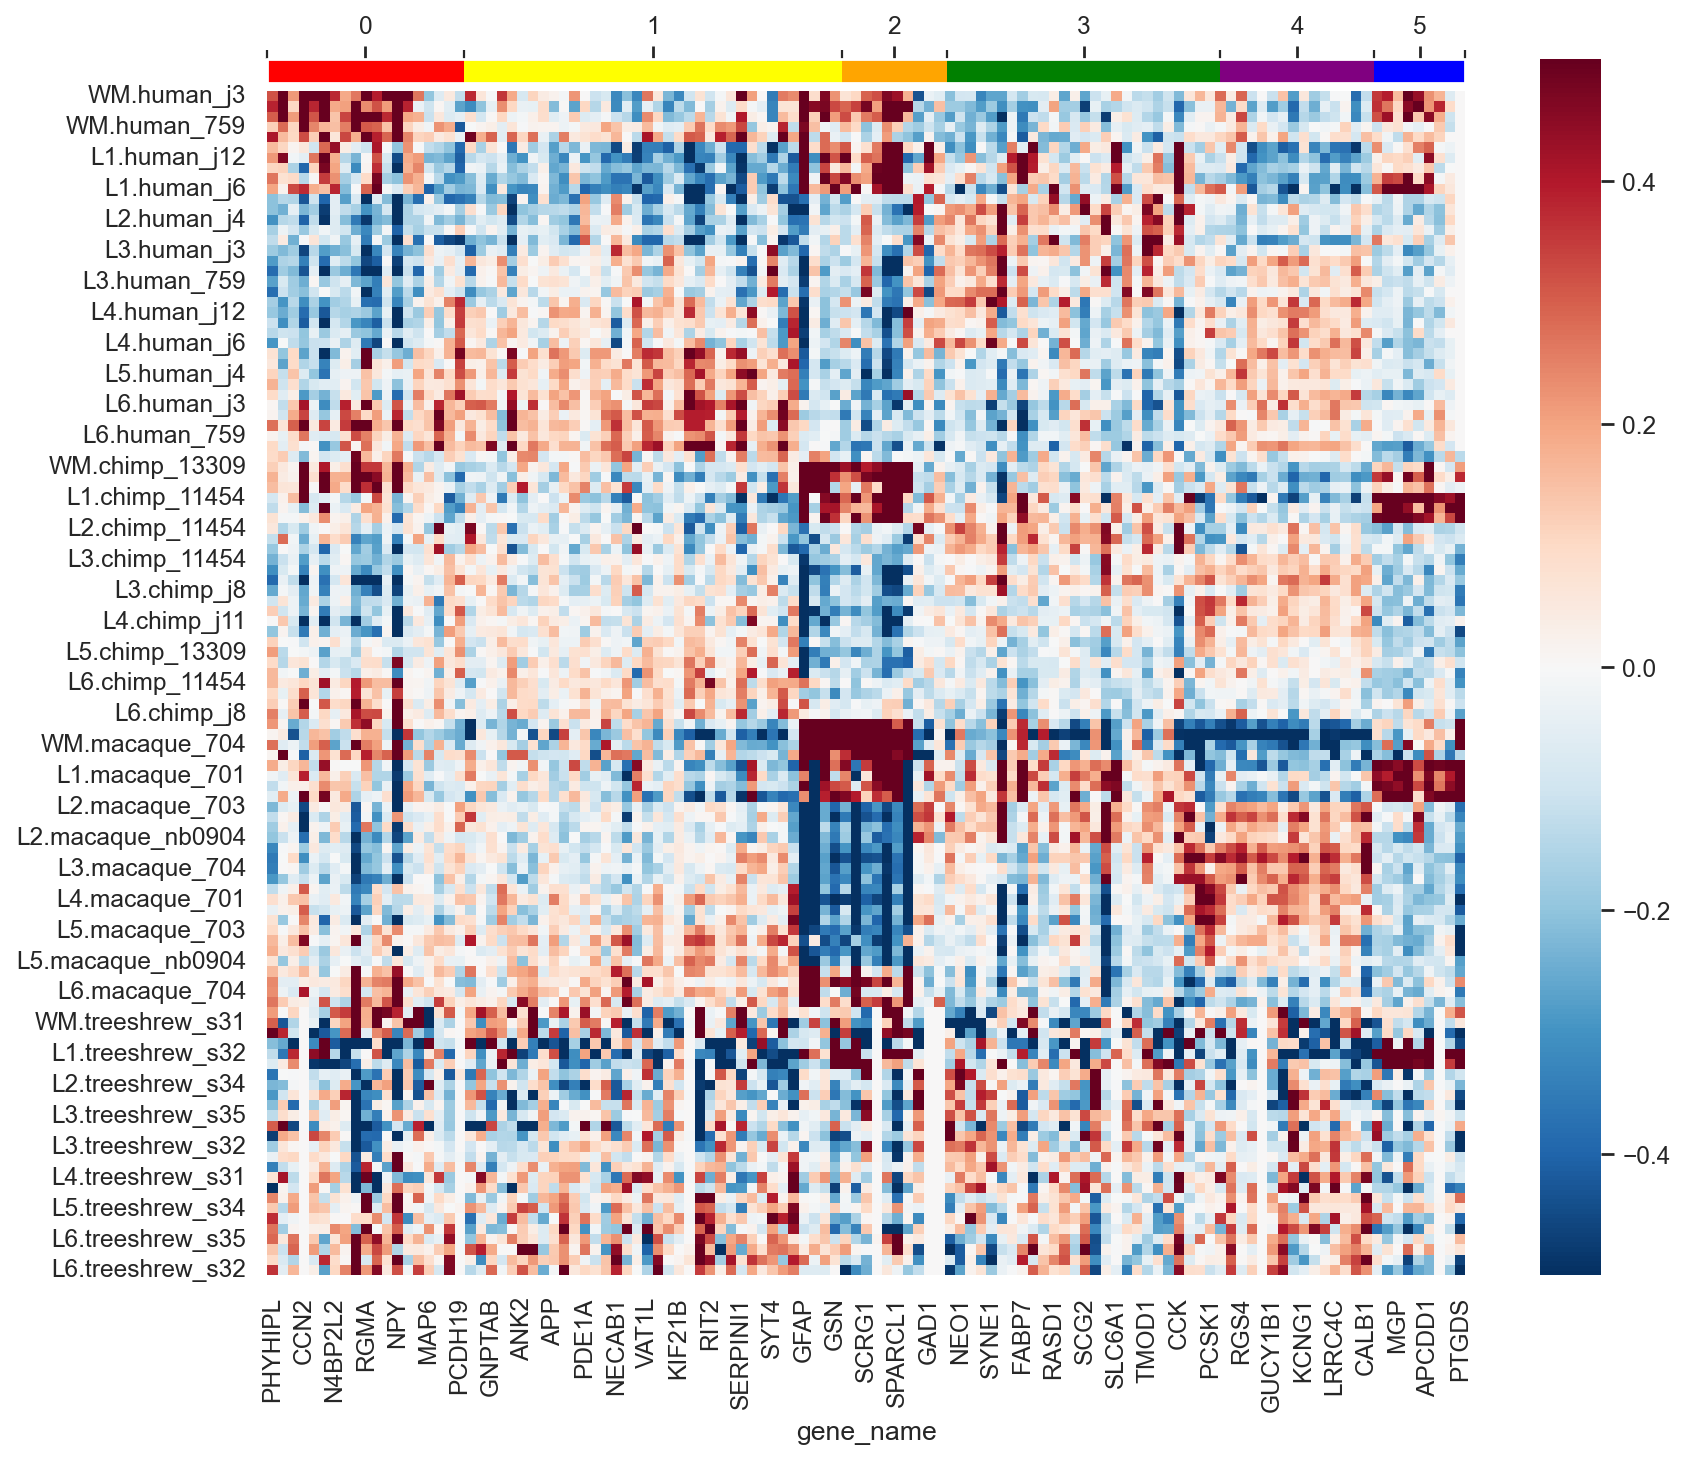

In [86]:
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(df_4spe_hs[order_4spe], ax=ax, cmap="RdBu_r", vmax=0.5, vmin=-0.5, center=0)
divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = mpl.colors.ListedColormap(colors)

cluster_size = labels.value_counts().loc[clusters].values
cluster_pos = cluster_size.cumsum()
bounds = [0] + list(cluster_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(cluster_pos - cluster_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(clusters))
cax.xaxis.tick_top()

## Cluster profiles (mean)

In [87]:
df_annotation = df_4spe_hs.copy()
df_annotation['layer'] = adata_pb_4spe.obs.layer
df_annotation['condition'] = adata_pb_4spe.obs.condition

In [88]:
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()

gene_name          IGSF21   CAMK2N1    SLC2A1    MAN1A2   S100A10      RGS4  \
condition layer                                                               
chimp     6a          NaN       NaN       NaN       NaN       NaN       NaN   
          L1    -0.231617 -0.100126  0.549012  0.226507  0.025641 -0.215088   
          L2    -0.164320 -0.045536 -0.105929 -0.075494 -0.004033 -0.280267   
          L3    -0.013440  0.078886 -0.085139 -0.287561 -0.141873  0.079573   
          L4     0.176425  0.037796 -0.159376 -0.323849  0.201904  0.192206   

gene_name          KIF21B     TMCC2      NID1    ZBTB18  ...     KCNG1  \
condition layer                                          ...             
chimp     6a          NaN       NaN       NaN       NaN  ...       NaN   
          L1    -0.061434  0.090244  0.772159 -0.137080  ... -0.163782   
          L2     0.055080  0.029616 -0.101655  0.238887  ...  0.003626   
          L3     0.114423  0.110009 -0.183162  0.185809  ...  0.160608   
          L4     0.066458 -0.001428 -0.167780  0.131912  ...  0.056947   

gene_name            DOK5     CBLN4   TMEM59L      ETFB      GNAZ      TSPO  \
condition layer                                                               
chimp     6a          NaN       NaN       NaN       NaN       NaN       NaN   
          L1    -0.012182  0.309610 -0.141558  0.162136 -0.039300  0.156637   
          L2     0.176226  0.122471 -0.012853 -0.038228  0.123926 -0.074830   
          L3     0.072969  0.016419  0.074497 -0.048922  0.102861 -0.067673   
          L4    -0.025213 -0.012583  0.036490  0.016441  0.079627 -0.098315   

gene_name           NCAM2      JAM2       APP  
condition layer                                
chimp     6a          NaN       NaN       NaN  
          L1     0.075177  0.285189 -0.117498  
          L2     0.041594 -0.111063 -0.100191  
          L3    -0.014084 -0.064058  0.082678  
          L4    -0.011287 -0.068254  0.083122  

[5 rows x 115 columns]

Text(0.5, 0.98, 'Mean everaging for profiles')

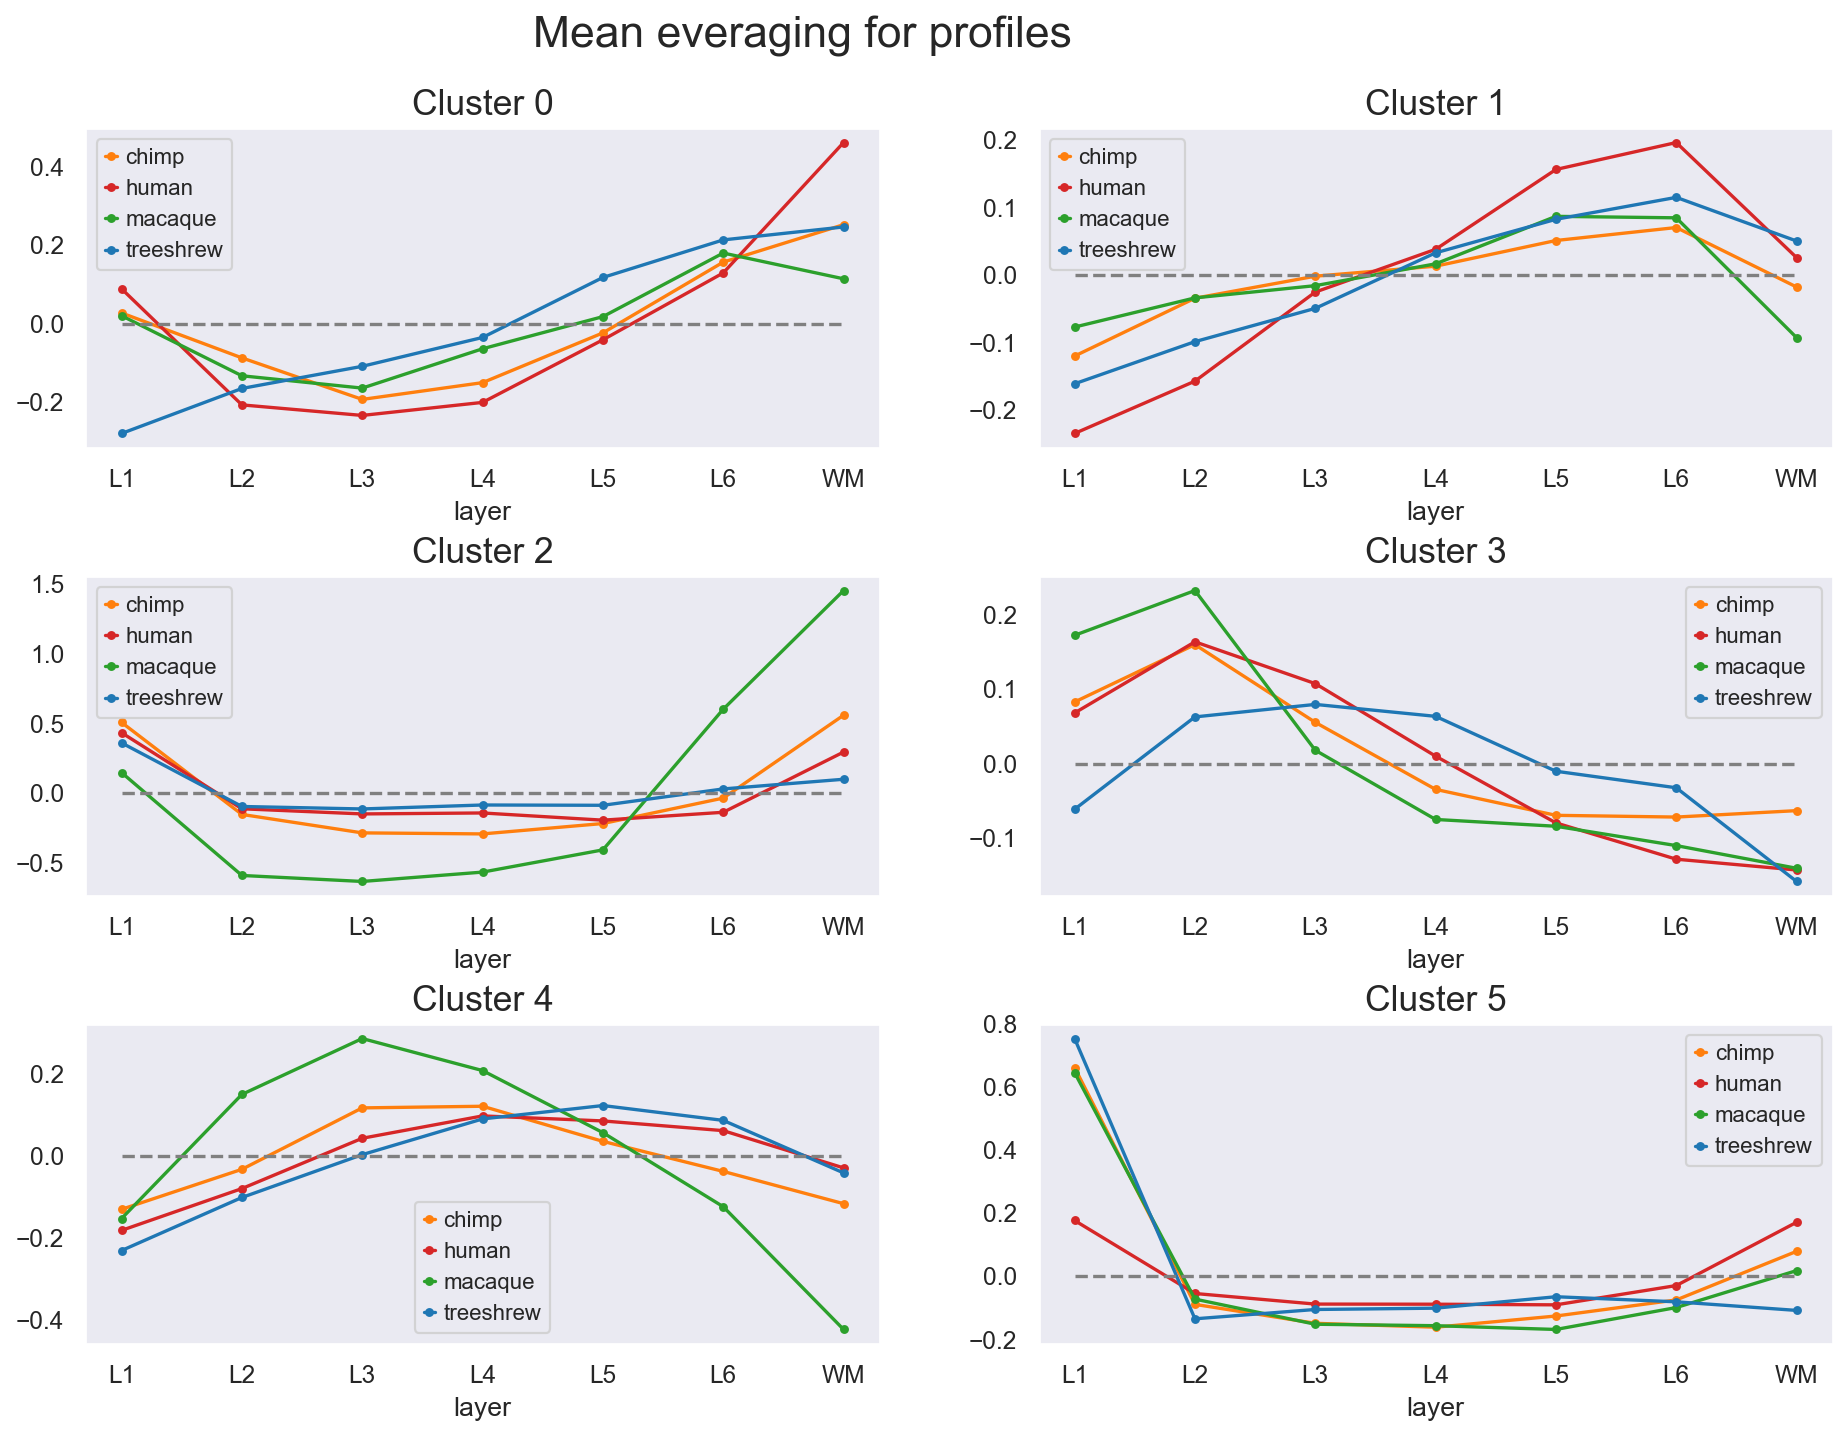

In [89]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.intersection(hs_genes_inter).tolist()

    (
        layer_mean[genes]
        .mean(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green', 'treeshrew': 'tab:blue'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

fig.suptitle('Mean everaging for profiles', fontsize=20)

## Cluster profiles (Median)

Text(0.5, 0.98, 'Median everaging for profiles')

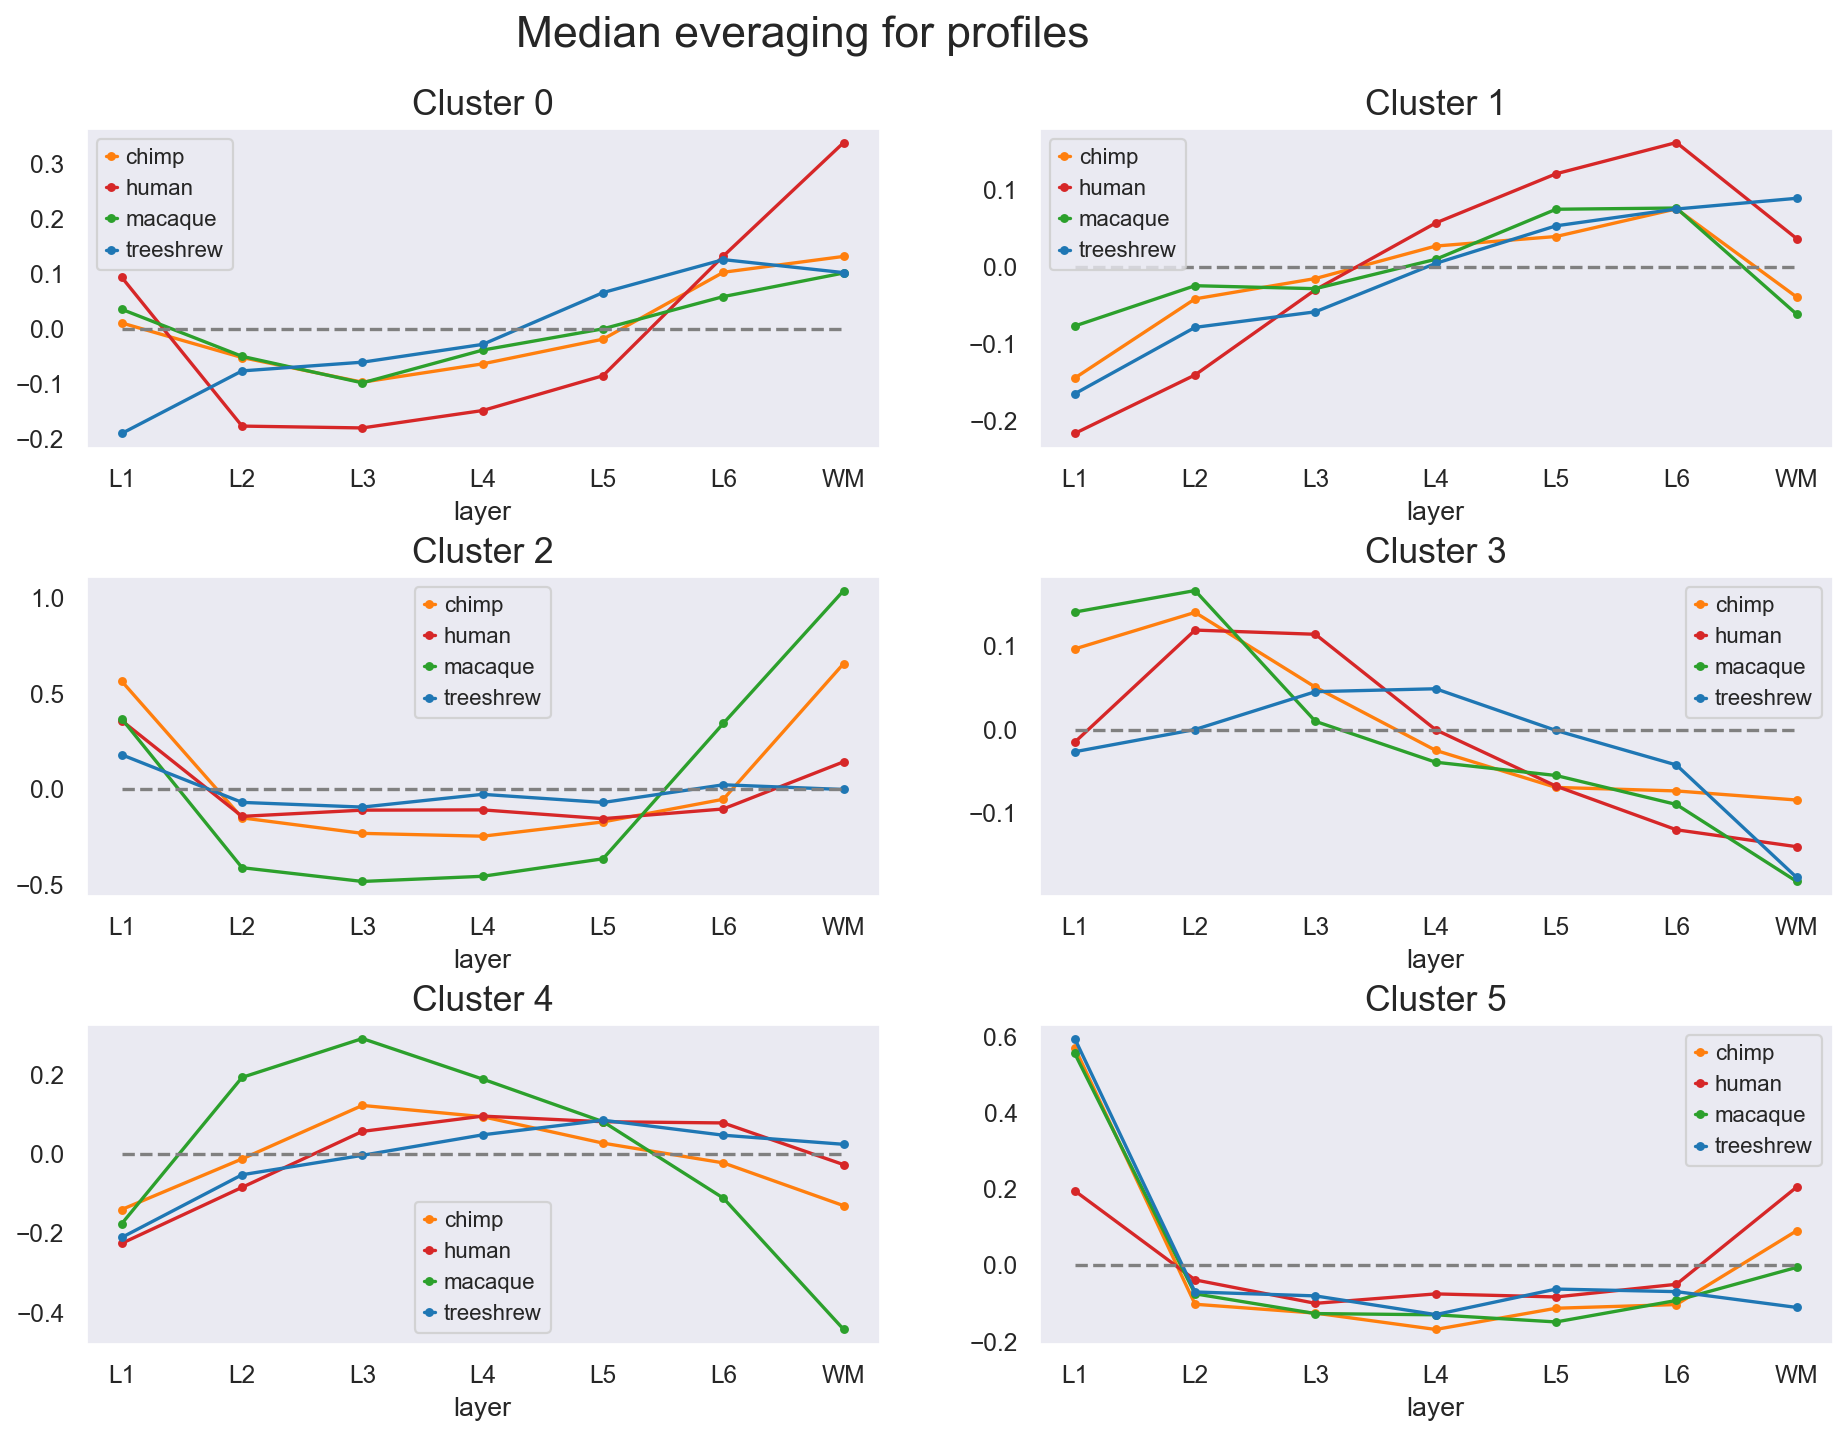

In [90]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.intersection(hs_genes_inter).tolist()

    (
        layer_mean[genes]
        .median(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green', 'treeshrew': 'tab:blue'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

fig.suptitle('Median everaging for profiles', fontsize=20)

# Intersection with ANOVA clusters

In [91]:
anova_hs_inter = hs_genes.intersection(anova_labels.index)
anova_hs_inter

Index(['ACTA2', 'ADI1', 'AKT3', 'ALCAM', 'ANK2', 'APBB2', 'APCDD1', 'APLP2',
       'APP', 'AQP4',
       ...
       'TSPO', 'TTC3', 'TTYH1', 'TUBA4A', 'UBAP2', 'VAT1L', 'VSTM2A', 'ZBTB18',
       'ZEB2', 'ZMYND8'],
      dtype='object', length=159)

In [92]:
table_to_pivot = pd.concat([anova_labels.loc[anova_hs_inter], labels.loc[anova_hs_inter]], axis=1)
table_to_pivot.columns = ['ANOVA_labels', 'hs_labels']
pivot_labels_inter = table_to_pivot.groupby('ANOVA_labels').value_counts().unstack().fillna(0)
pivot_labels_inter

hs_labels        0     1    2     3     4     5
ANOVA_labels                                   
0              0.0   1.0  0.0  23.0   0.0   0.0
1              5.0   7.0  0.0   1.0   1.0   0.0
2              1.0  39.0  0.0   4.0   2.0   0.0
3              0.0   0.0  8.0   0.0   0.0   0.0
4              4.0   2.0  0.0   1.0   0.0   1.0
5              1.0   2.0  0.0   4.0  17.0   0.0
6             13.0   1.0  6.0   5.0   0.0  10.0

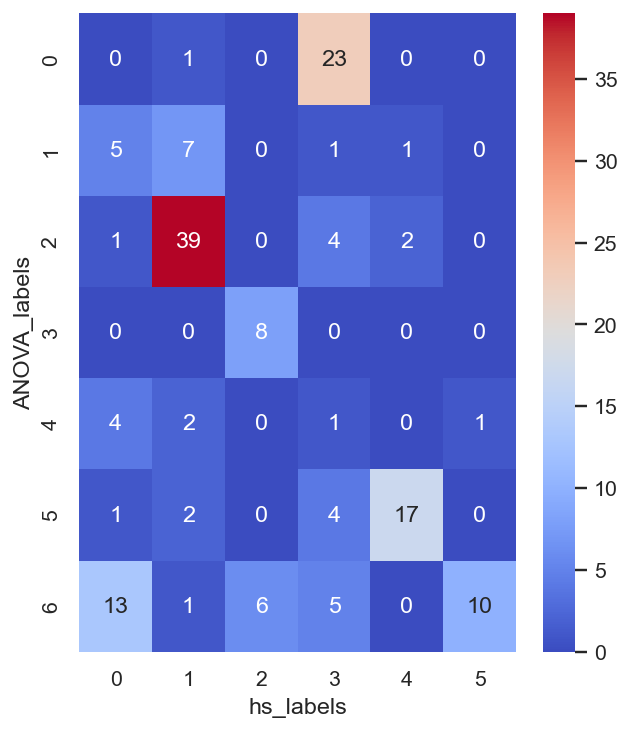

In [93]:
plt.figure(figsize=(5, 6), dpi=70)
sns.set(font_scale=1)
sns.heatmap(pivot_labels_inter, annot=True, cmap = 'coolwarm', fmt=".0f")
plt.grid(False)

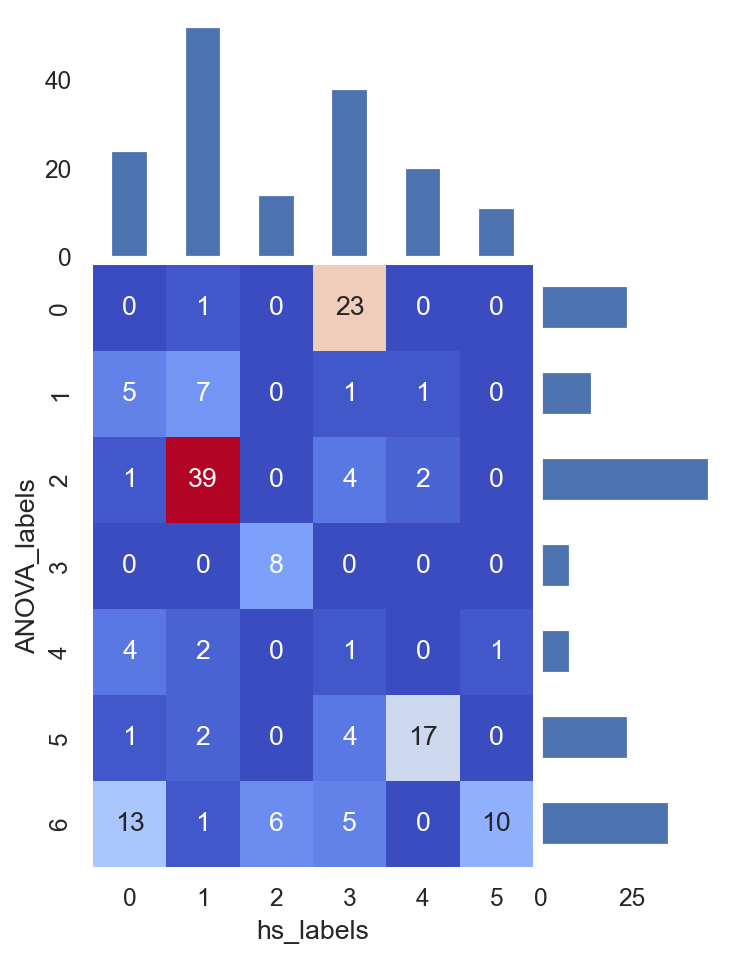

In [94]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(5, 7))
sns.heatmap(pivot_labels_inter, annot=True, cmap = 'coolwarm', fmt=".0f", ax=ax, cbar=False)


divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='40%', pad=0.05)
pivot_labels_inter.sum(axis=0).plot.bar(ax=cax)
cax.set_facecolor(color='white')
cax.get_xaxis().set_visible(False)

cax = divider.append_axes('right', size='40%', pad=0.05)
index_order = pivot_labels_inter.index[::-1]
pivot_labels_inter.sum(axis=1).loc[index_order].plot.barh(ax=cax)
cax.set_facecolor(color='white')
cax.get_yaxis().set_visible(False)

# Functional analysis

In [95]:
gene_clust = list()
enrich_results = list()

for label in tqdm(sorted(labels.unique())):
    genes = labels[labels == label].index.tolist()
    descr = f'Genes for spectral clustering ({n_clusters} clusters) of human-specific genes. Cluster label: {label}'
    gene_clust.append(GeneCluster(genes, descr, label, background_genes))
    time.sleep(1)

  0%|          | 0/6 [00:00<?, ?it/s]

## GO_Biological_Process_2021

In [96]:
GeneCluster.enrich_geneclusters(gene_clust, 'GO_Biological_Process_2021')

In [97]:
enrich_res = pd.concat([gc.enrichment_res['GO_Biological_Process_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val    Z-score  \
Term                                                                            
SRP-dependent cotranslational protein targeting...     1  0.000805  18.873103   
cotranslational protein targeting to membrane (...     2  0.000927  17.939016   
transition metal ion transport (GO:0000041)            3  0.001179  47.000000   
protein targeting to ER (GO:0045047)                   4  0.001305  15.845217   
nuclear-transcribed mRNA catabolic process, non...     5  0.001899  13.824304   

                                                    Combined score  \
Term                                                                 
SRP-dependent cotranslational protein targeting...      134.454619   
cotranslational protein targeting to membrane (...      125.283225   
transition metal ion transport (GO:0000041)             316.926248   
protein targeting to ER (GO:0045047)                    105.234519   
nuclear-transcribed mRNA catabolic process, non...       86.628068   

                                                        Overlapping genes  \
Term                                                                        
SRP-dependent cotranslational protein targeting...  [RPL31, RPL12, RPLP2]   
cotranslational protein targeting to membrane (...  [RPL31, RPL12, RPLP2]   
transition metal ion transport (GO:0000041)                 [TTYH1, FTH1]   
protein targeting to ER (GO:0045047)                [RPL31, RPL12, RPLP2]   
nuclear-transcribed mRNA catabolic process, non...  [RPL31, RPL12, RPLP2]   

                                                    Adjusted P-value  \
Term                                                                   
SRP-dependent cotranslational protein targeting...          0.080596   
cotranslational protein targeting to membrane (...          0.080596   
transition metal ion transport (GO:0000041)                 0.080596   
protein targeting to ER (GO:0045047)                        0.080596   
nuclear-transcribed mRNA catabolic process, non...          0.093817   

                                                    Old p-value  \
Term                                                              
SRP-dependent cotranslational protein targeting...            0   
cotranslational protein targeting to membrane (...            0   
transition metal ion transport (GO:0000041)                   0   
protein targeting to ER (GO:0045047)                          0   
nuclear-transcribed mRNA catabolic process, non...            0   

                                                    Old adjusted p-value  \
Term                                                                       
SRP-dependent cotranslational protein targeting...                     0   
cotranslational protein targeting to membrane (...                     0   
transition metal ion transport (GO:0000041)                            0   
protein targeting to ER (GO:0045047)                                   0   
nuclear-transcribed mRNA catabolic process, non...                     0   

                                                    num_overlap_genes  \
Term                                                                    
SRP-dependent cotranslational protein targeting...                  3   
cotranslational protein targeting to membrane (...                  3   
transition metal ion transport (GO:0000041)                         2   
protein targeting to ER (GO:0045047)                                3   
nuclear-transcribed mRNA catabolic process, non...                  3   

                                                    neg_log10(p_adj)  \
Term                                                                   
SRP-dependent cotranslational protein targeting...          1.093689   
cotranslational protein targeting to membrane (...          1.093689   
transition metal ion transport (GO:0000041)                 1.093689   
protein targeting to ER (GO:0045047)                        1.093689   
n

In [98]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

28

In [99]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

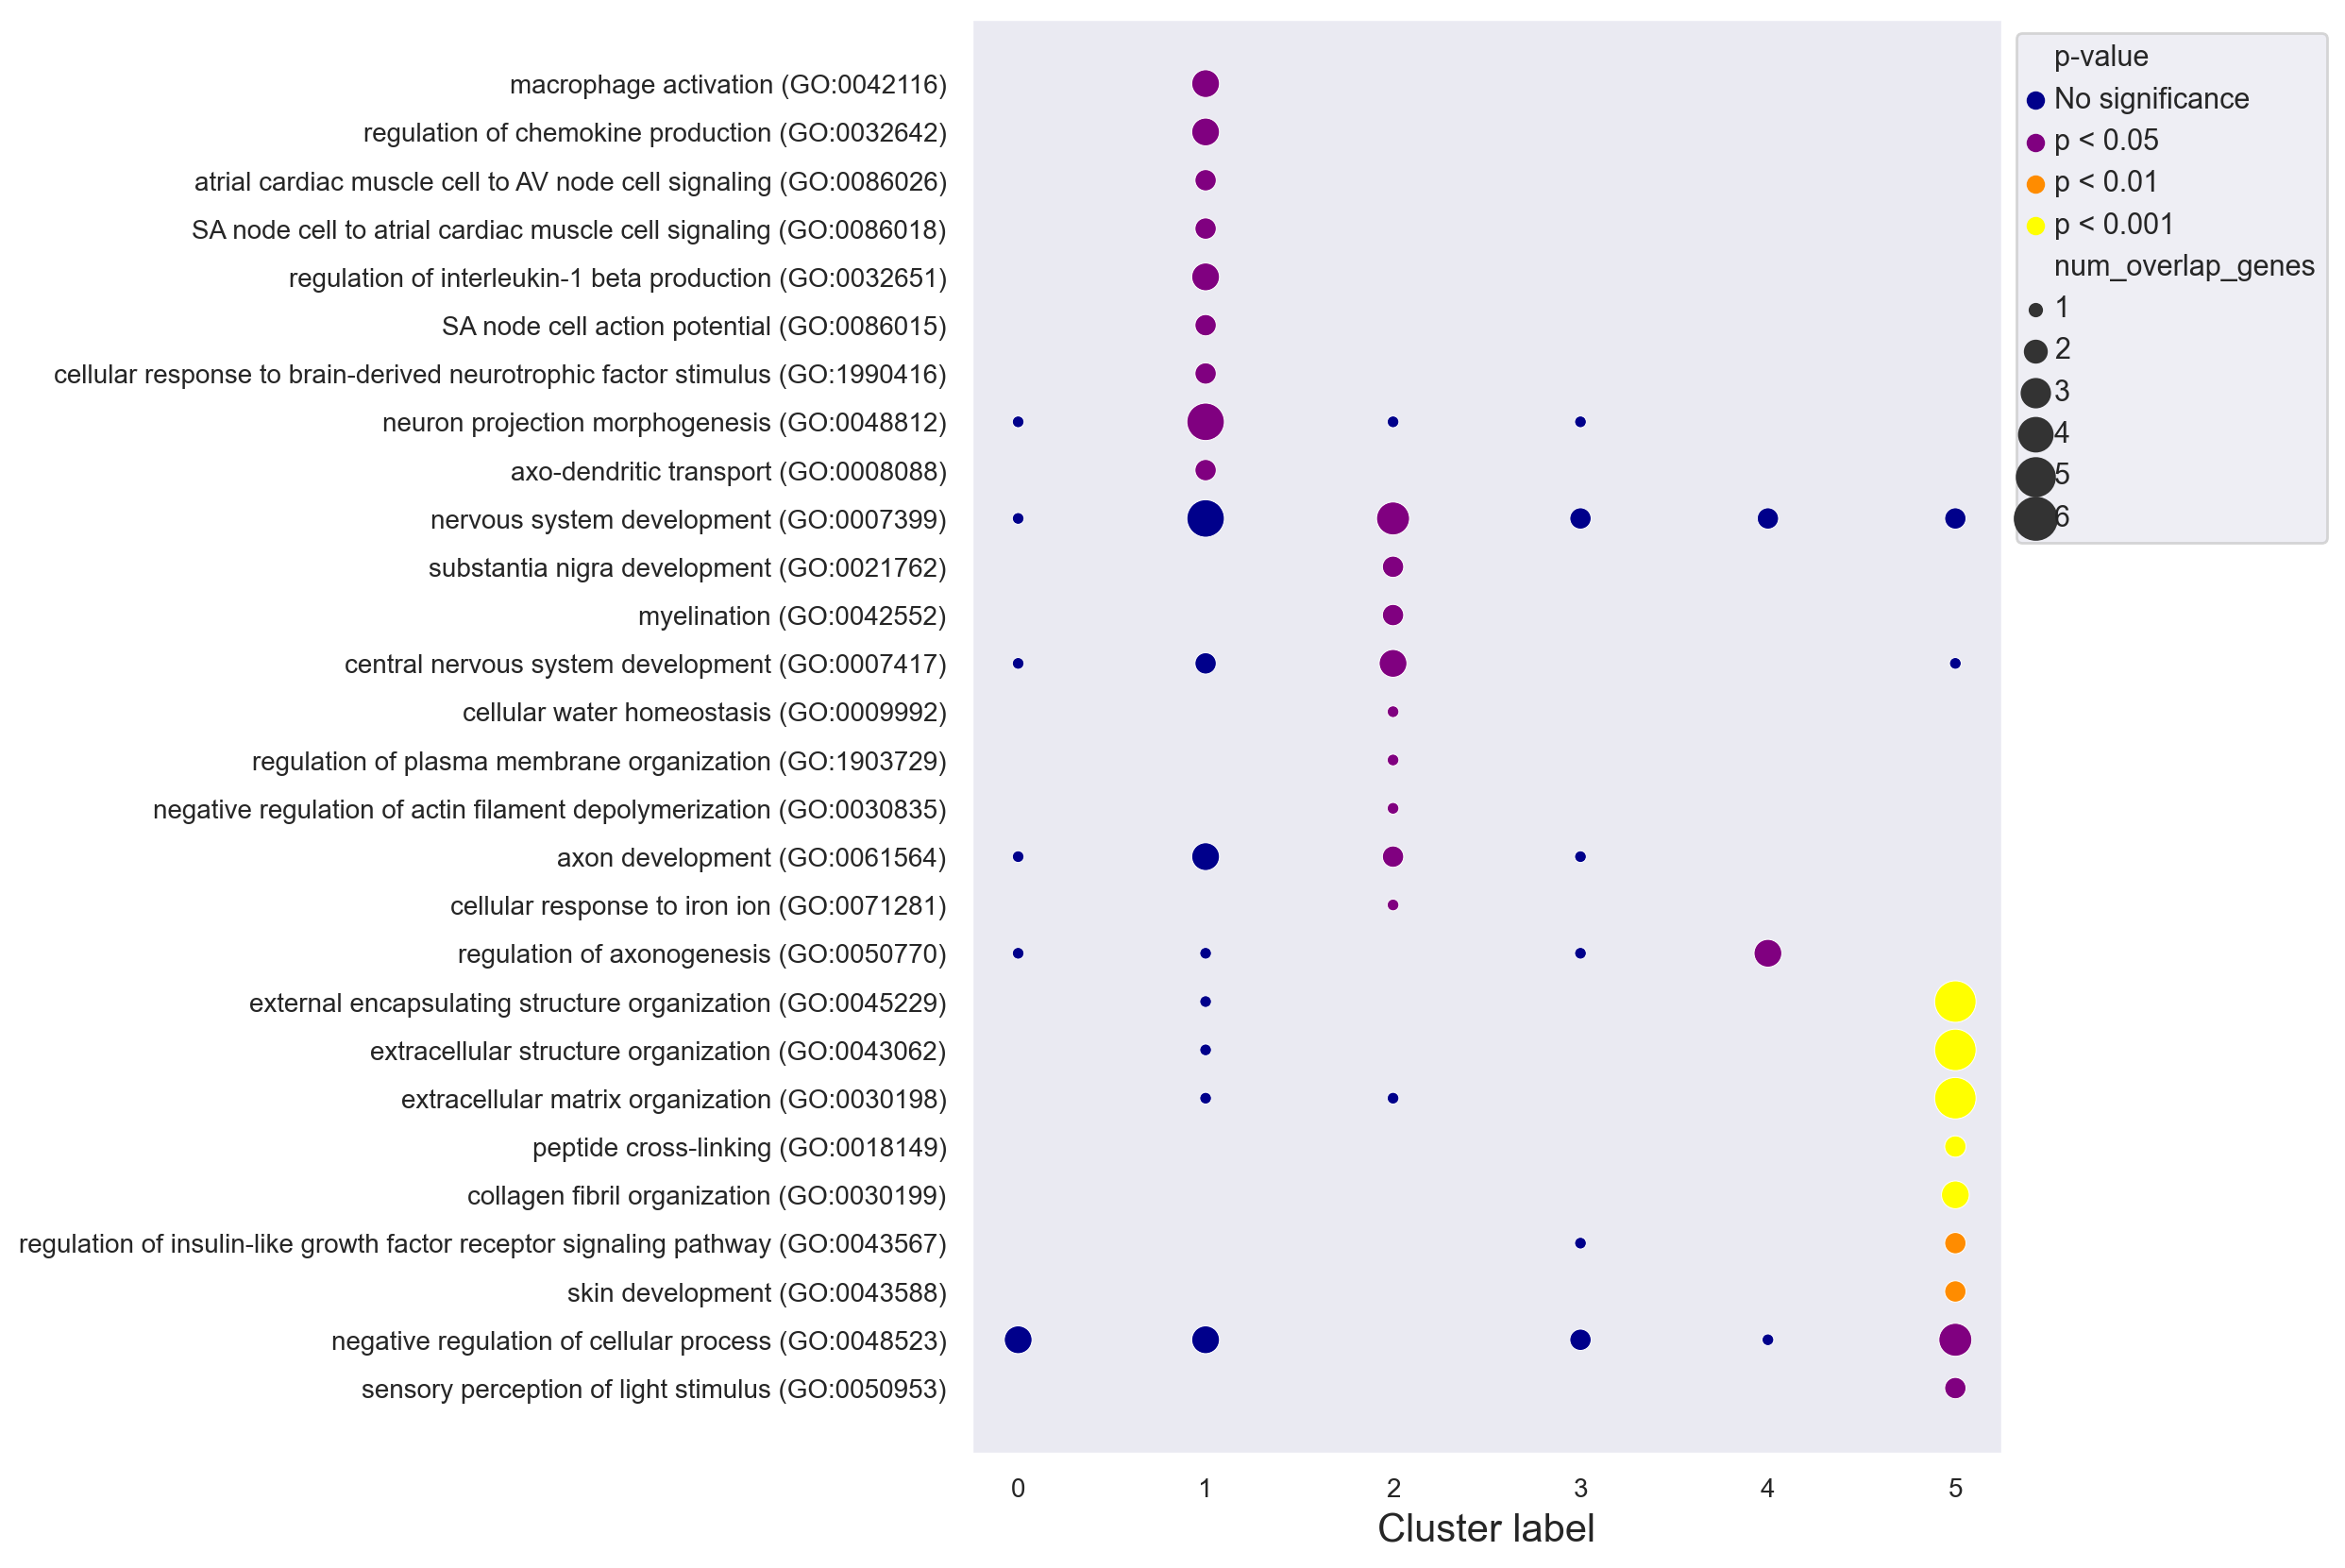

In [100]:
fig = plt.figure(figsize=(7, 10), dpi=100)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Azimuth Cell Types 2021


In [101]:
GeneCluster.enrich_geneclusters(gene_clust, 'Azimuth_Cell_Types_2021')

In [102]:
enrich_res = pd.concat([gc.enrichment_res['Azimuth_Cell_Types_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val     Z-score  \
Term                                                                          
Naive B Cell CL0000788                              1  0.006073  339.962963   
SST+ NPY+ Layer 1-6 GABAergic Neuron CL0000617      2  0.009096  169.962963   
Sst+ Chodl+ GABAergic Neuron CL0000617              3  0.009096  169.962963   
VIP+ TAC3+ Layer 3-5 GABAergic Neuron CL0000617     4  0.012110  113.296296   
Gamma Islet Cell CL0002275                          5  0.012110  113.296296   

                                                 Combined score  \
Term                                                              
Naive B Cell CL0000788                              1735.156044   
SST+ NPY+ Layer 1-6 GABAergic Neuron CL0000617       798.818433   
Sst+ Chodl+ GABAergic Neuron CL0000617               798.818433   
VIP+ TAC3+ Layer 3-5 GABAergic Neuron CL0000617      500.060255   
Gamma Islet Cell CL0002275                           500.060255   

                                                Overlapping genes  \
Term                                                                
Naive B Cell CL0000788                                     [BTG1]   
SST+ NPY+ Layer 1-6 GABAergic Neuron CL0000617              [NPY]   
Sst+ Chodl+ GABAergic Neuron CL0000617                      [NPY]   
VIP+ TAC3+ Layer 3-5 GABAergic Neuron CL0000617           [NCAM2]   
Gamma Islet Cell CL0002275                                  [ID2]   

                                                 Adjusted P-value  \
Term                                                                
Naive B Cell CL0000788                                   0.023017   
SST+ NPY+ Layer 1-6 GABAergic Neuron CL0000617           0.023017   
Sst+ Chodl+ GABAergic Neuron CL0000617                   0.023017   
VIP+ TAC3+ Layer 3-5 GABAergic Neuron CL0000617          0.023017   
Gamma Islet Cell CL0002275                               0.023017   

                                                 Old p-value  \
Term                                                           
Naive B Cell CL0000788                                     0   
SST+ NPY+ Layer 1-6 GABAergic Neuron CL0000617             0   
Sst+ Chodl+ GABAergic Neuron CL0000617                     0   
VIP+ TAC3+ Layer 3-5 GABAergic Neuron CL0000617            0   
Gamma Islet Cell CL0002275                                 0   

                                                 Old adjusted p-value  \
Term                                                                    
Naive B Cell CL0000788                                              0   
SST+ NPY+ Layer 1-6 GABAergic Neuron CL0000617                      0   
Sst+ Chodl+ GABAergic Neuron CL0000617                              0   
VIP+ TAC3+ Layer 3-5 GABAergic Neuron CL0000617                     0   
Gamma Islet Cell CL0002275                                          0   

                                                 num_overlap_genes  \
Term                                                                 
Naive B Cell CL0000788                                           1   
SST+ NPY+ Layer 1-6 GABAergic Neuron CL0000617                   1   
Sst+ Chodl+ GABAergic Neuron CL0000617                           1   
VIP+ TAC3+ Layer 3-5 GABAergic Neuron CL0000617                  1   
Gamma Islet Cell CL0002275                                       1   

                                                 neg_log10(p_adj)  \
Term                                                                
Naive B Cell CL0000788                                   1.637943   
SST+ NPY+ Layer 1-6 GABAergic Neuron CL0000617           1.637943   
Sst+ Chodl+ GABAergic Neuron CL0000617                   1.637943   
VIP+ TAC3+ Layer 3-5 GABAergic Neuron CL0000617          1.637943   
Gamma Islet Cell CL0002275                               1.637943   

                                                 cluster_label  
Term                                                    

In [103]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

49

In [104]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

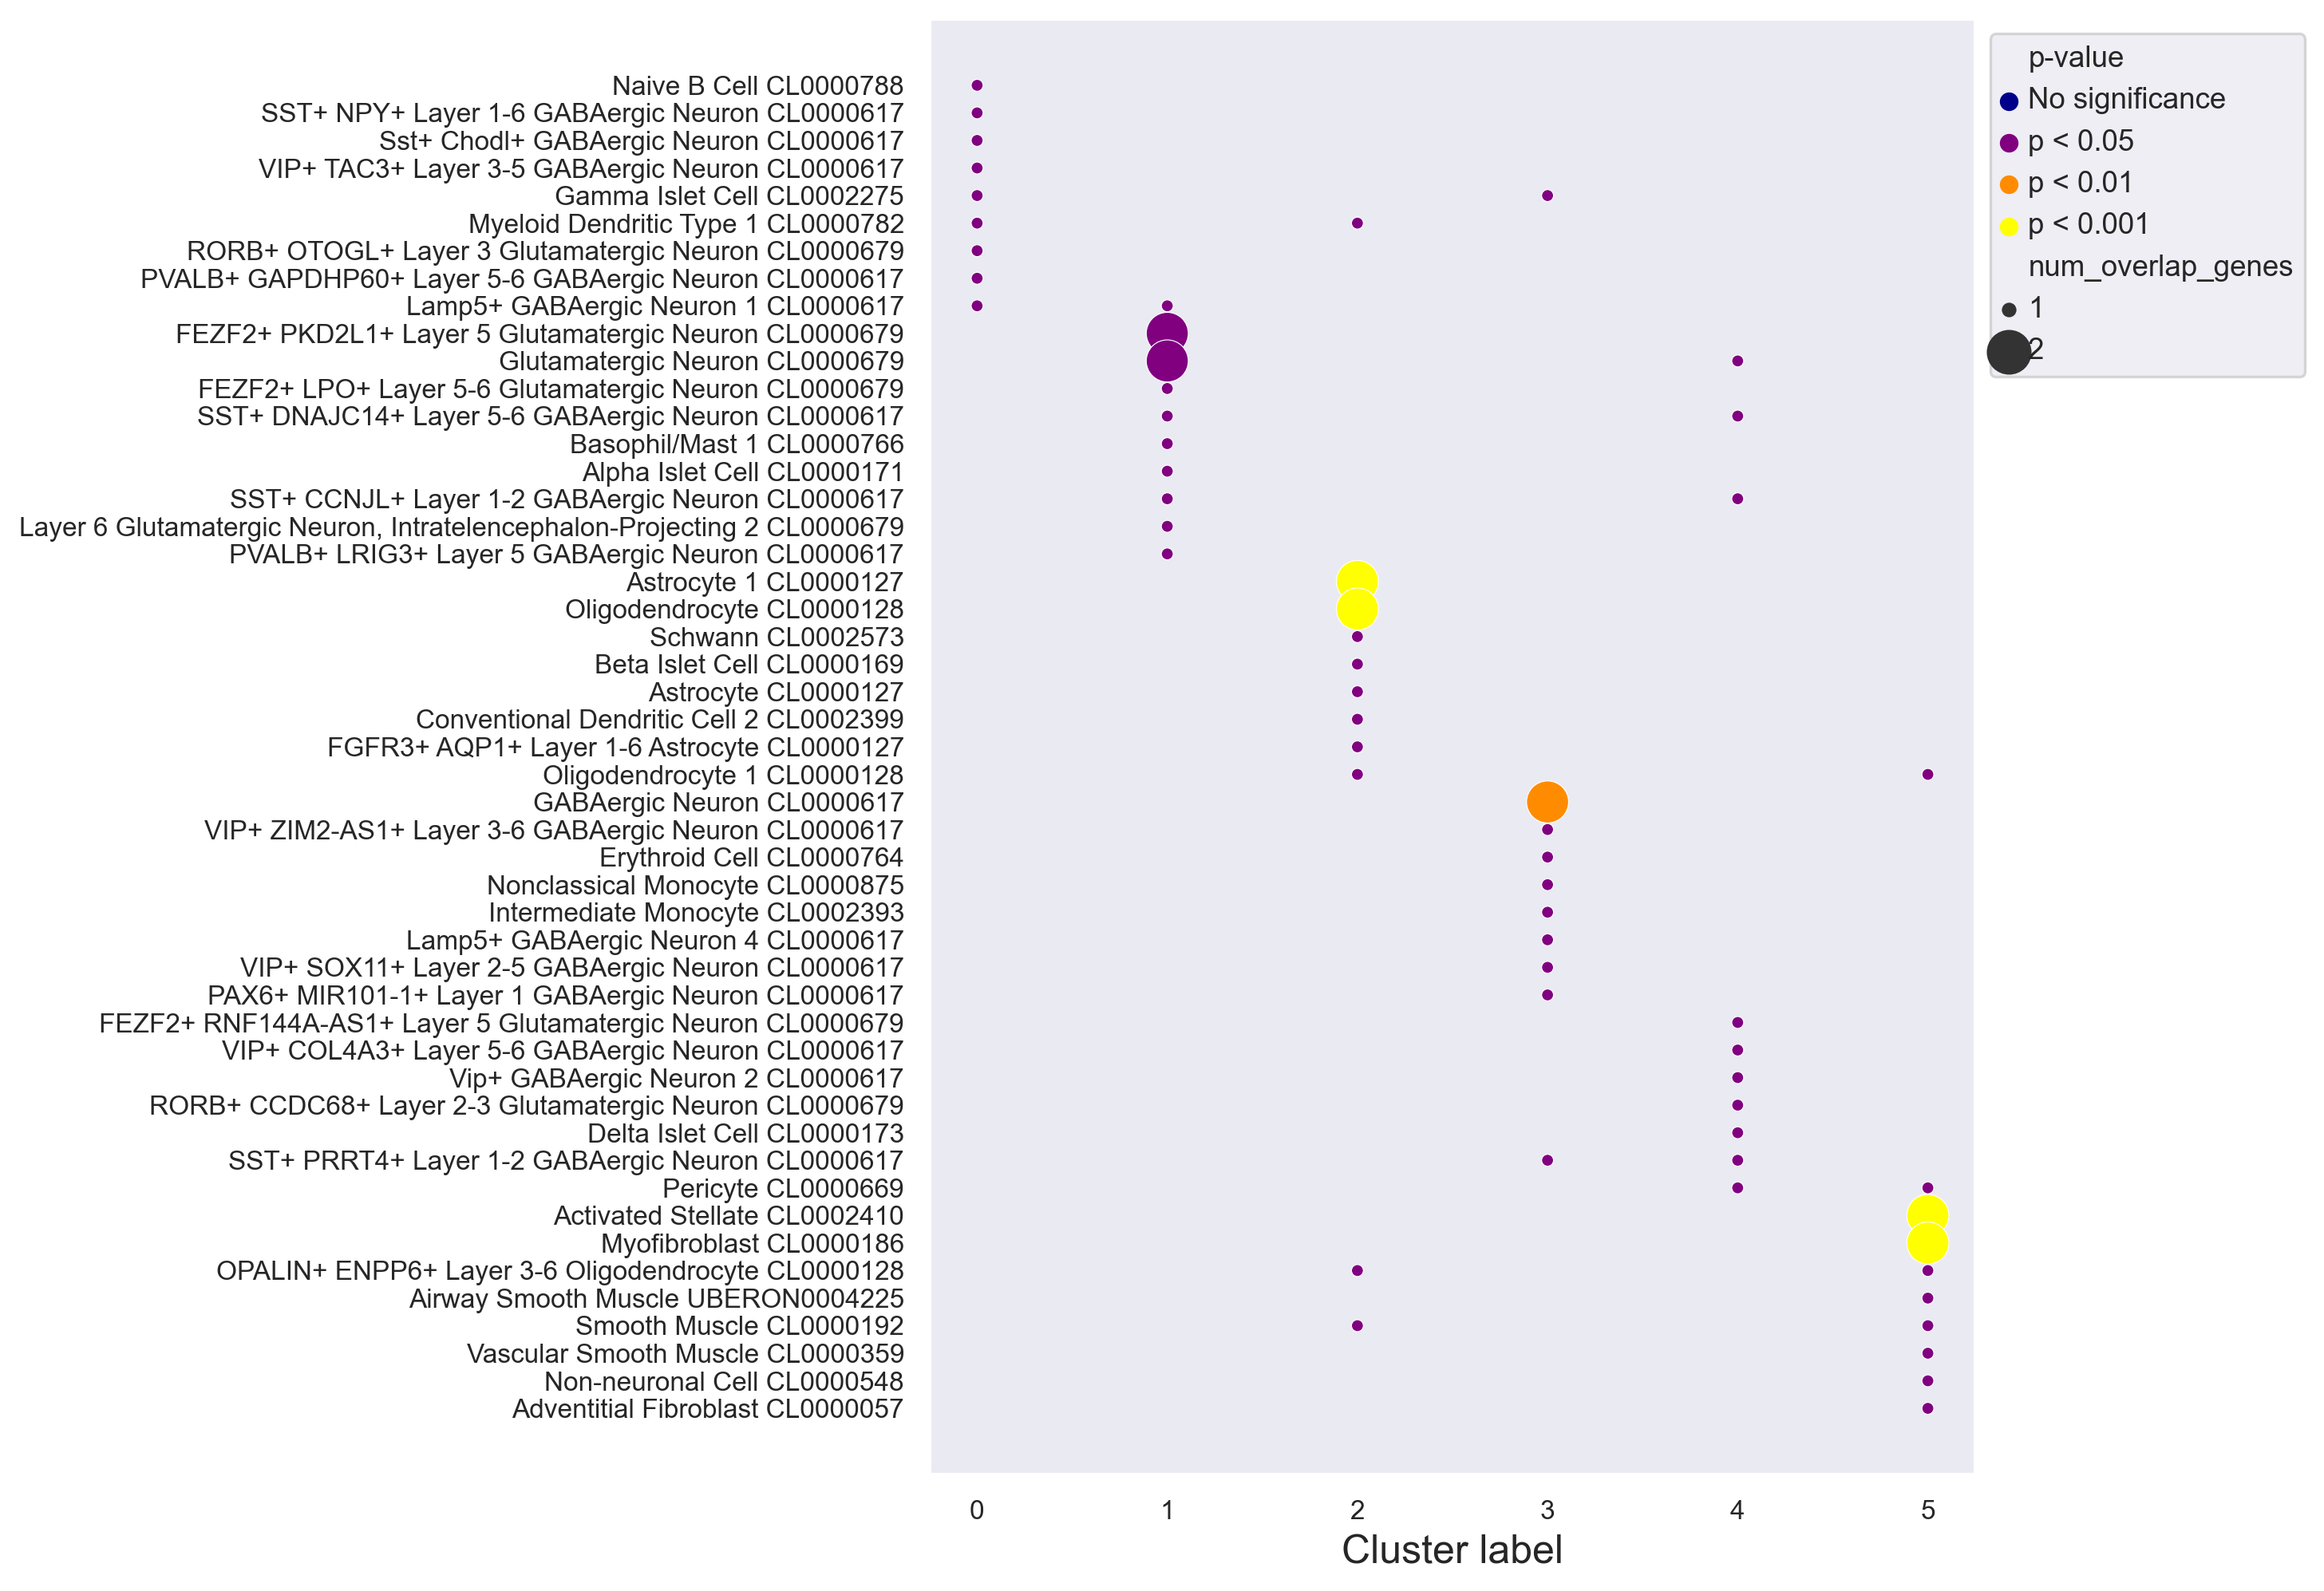

In [105]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## MGI_Mammalian_Phenotype_Level_4_2021

In [106]:
GeneCluster.enrich_geneclusters(gene_clust, 'MGI_Mammalian_Phenotype_Level_4_2021')

In [107]:
enrich_res = pd.concat([gc.enrichment_res['MGI_Mammalian_Phenotype_Level_4_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val     Z-score  \
Term                                                                          
abnormal olfactory system physiology MP:0001983     1  0.006073  339.962963   
abnormal olfactory bulb morphology MP:0000819       2  0.007122   17.576923   
increased cell nucleus count MP:0003707             3  0.009096  169.962963   
distended ileum MP:0009485                          4  0.009096  169.962963   
abnormal primitive streak elongation MP:0012685     5  0.012110  113.296296   

                                                 Combined score  \
Term                                                              
abnormal olfactory system physiology MP:0001983     1735.156044   
abnormal olfactory bulb morphology MP:0000819         86.910467   
increased cell nucleus count MP:0003707              798.818433   
distended ileum MP:0009485                           798.818433   
abnormal primitive streak elongation MP:0012685      500.060255   

                                                Overlapping genes  \
Term                                                                
abnormal olfactory system physiology MP:0001983           [NCAM2]   
abnormal olfactory bulb morphology MP:0000819        [ID2, NCAM2]   
increased cell nucleus count MP:0003707                   [TTYH1]   
distended ileum MP:0009485                                  [ID2]   
abnormal primitive streak elongation MP:0012685            [BPTF]   

                                                 Adjusted P-value  \
Term                                                                
abnormal olfactory system physiology MP:0001983          0.143936   
abnormal olfactory bulb morphology MP:0000819            0.143936   
increased cell nucleus count MP:0003707                  0.143936   
distended ileum MP:0009485                               0.143936   
abnormal primitive streak elongation MP:0012685          0.143936   

                                                 Old p-value  \
Term                                                           
abnormal olfactory system physiology MP:0001983            0   
abnormal olfactory bulb morphology MP:0000819              0   
increased cell nucleus count MP:0003707                    0   
distended ileum MP:0009485                                 0   
abnormal primitive streak elongation MP:0012685            0   

                                                 Old adjusted p-value  \
Term                                                                    
abnormal olfactory system physiology MP:0001983                     0   
abnormal olfactory bulb morphology MP:0000819                       0   
increased cell nucleus count MP:0003707                             0   
distended ileum MP:0009485                                          0   
abnormal primitive streak elongation MP:0012685                     0   

                                                 num_overlap_genes  \
Term                                                                 
abnormal olfactory system physiology MP:0001983                  1   
abnormal olfactory bulb morphology MP:0000819                    2   
increased cell nucleus count MP:0003707                          1   
distended ileum MP:0009485                                       1   
abnormal primitive streak elongation MP:0012685                  1   

                                                 neg_log10(p_adj)  \
Term                                                                
abnormal olfactory system physiology MP:0001983           0.84183   
abnormal olfactory bulb morphology MP:0000819             0.84183   
increased cell nucleus count MP:0003707                   0.84183   
distended ileum MP:0009485                                0.84183   
abnormal primitive streak elongation MP:0012685           0.84183   

                                                 cluster_label  
Term                                                    

In [108]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

27

In [109]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

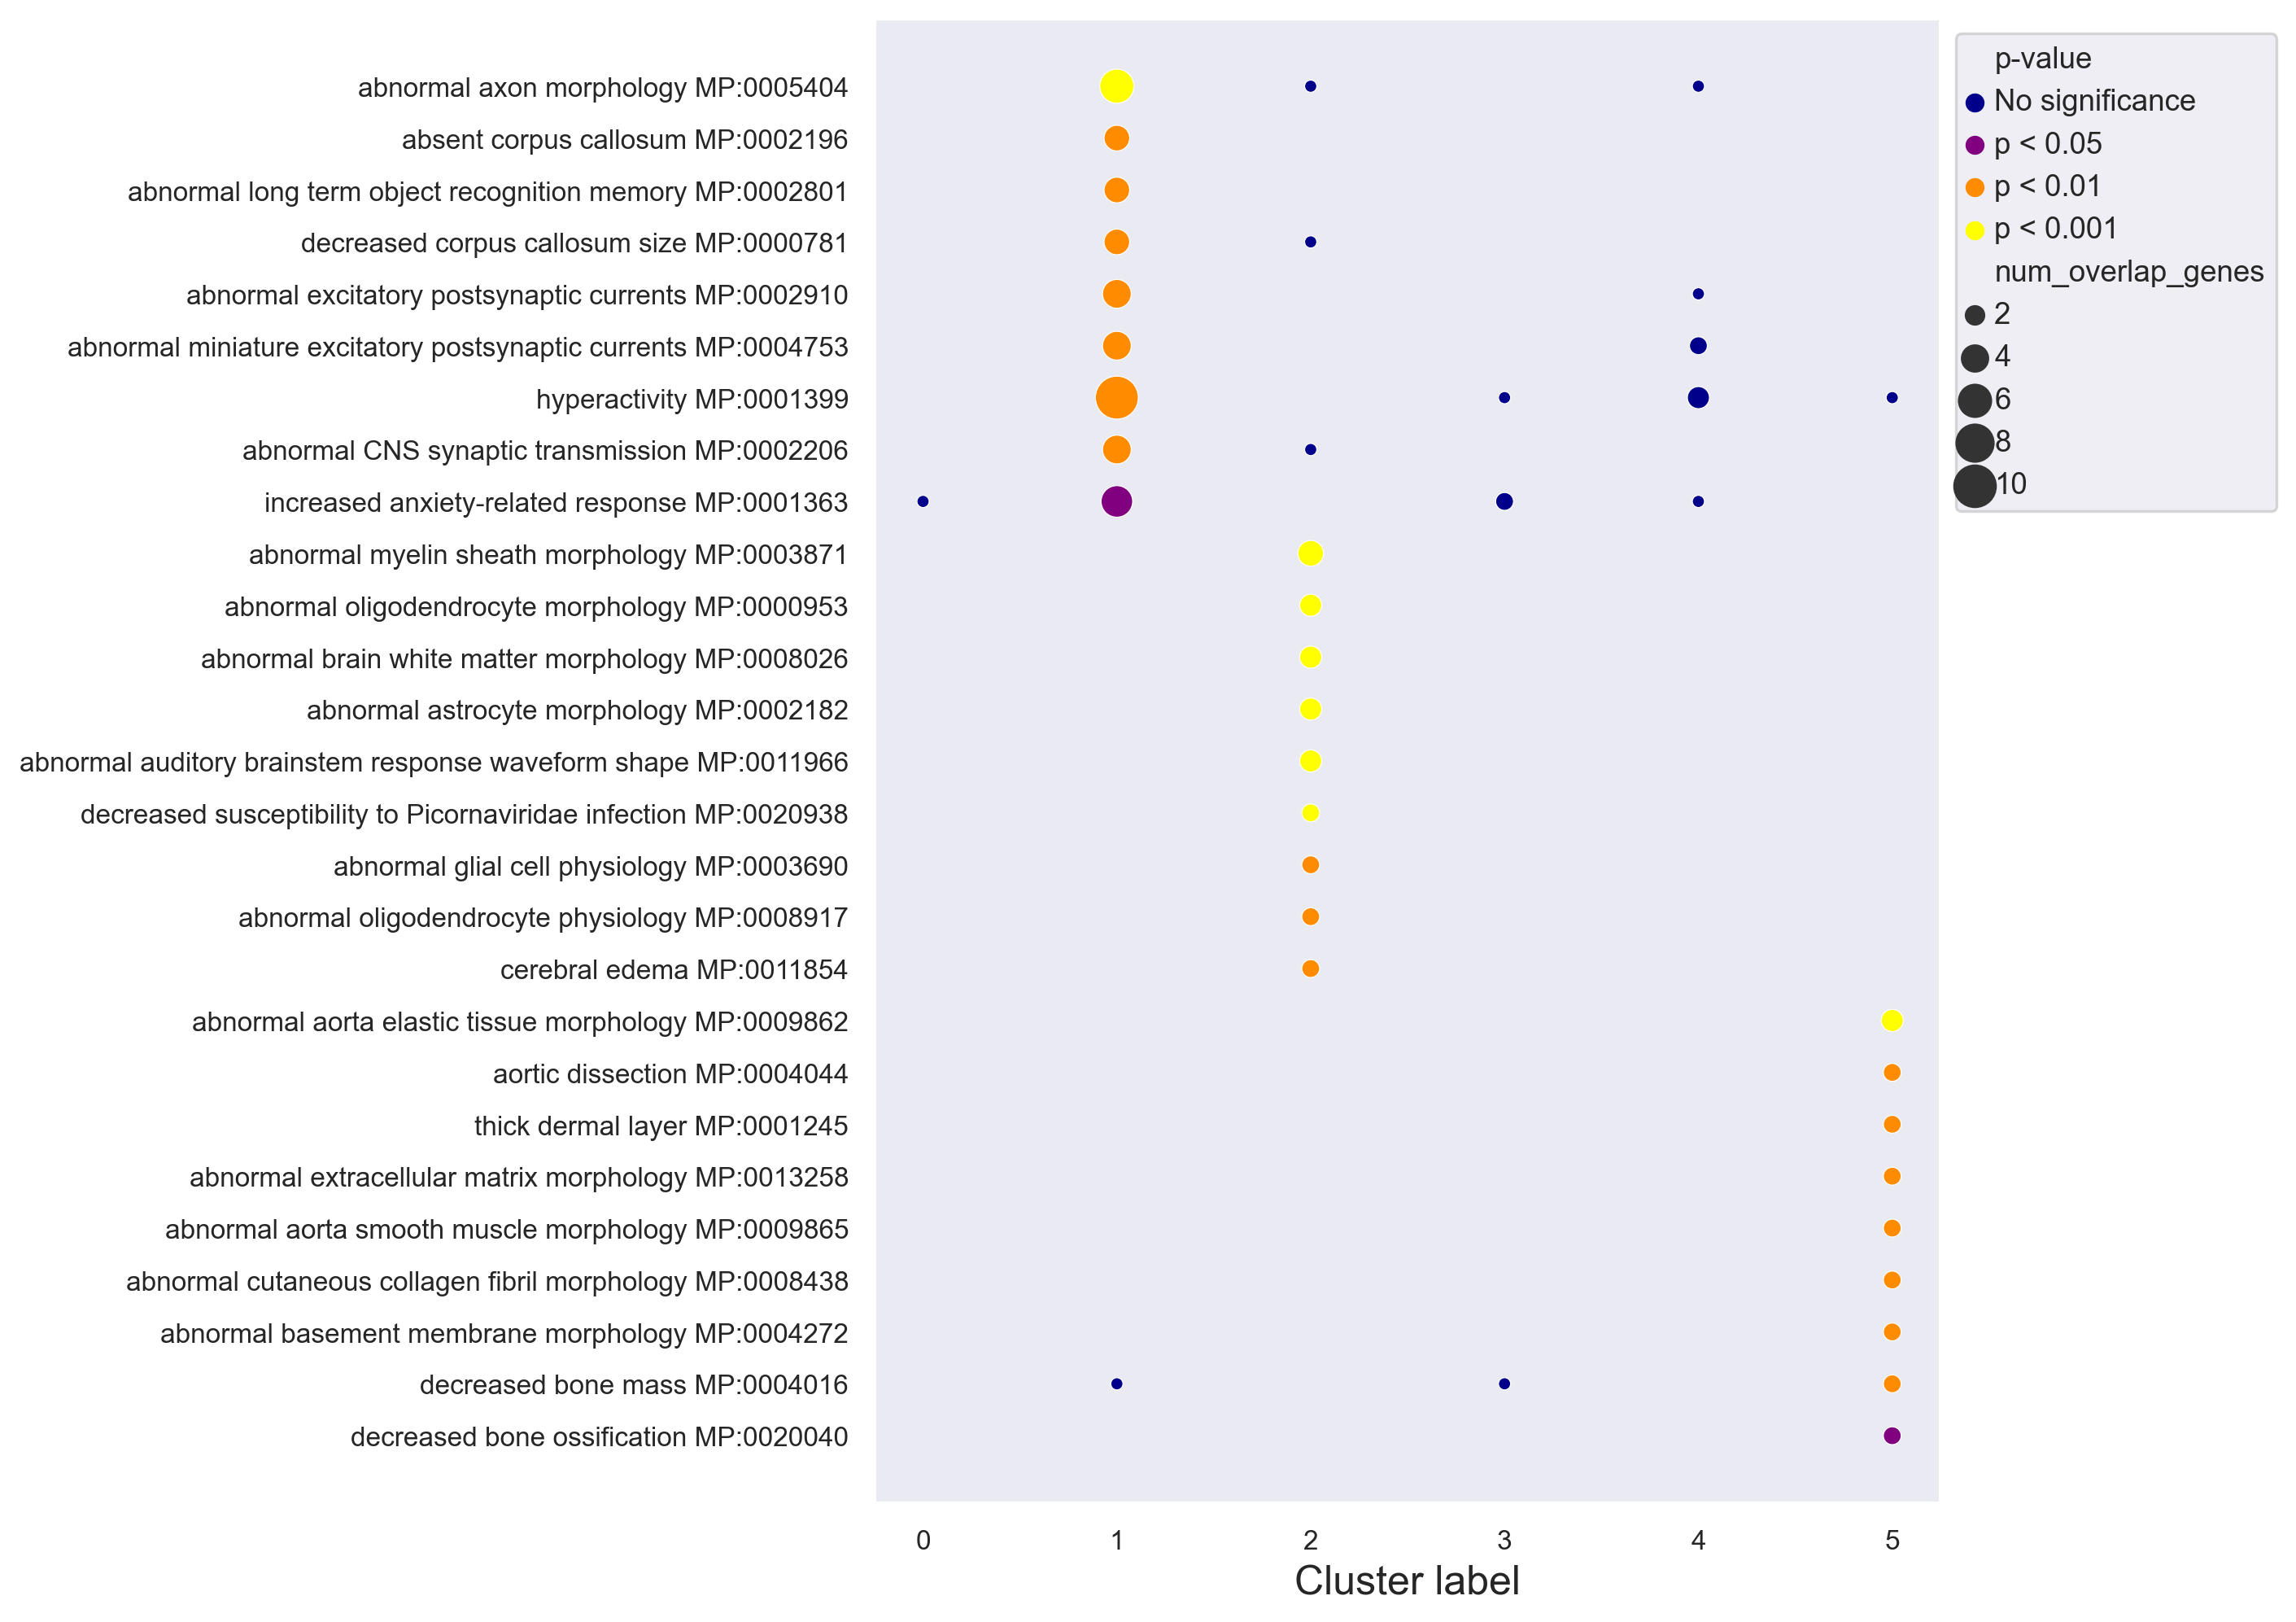

In [110]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Reactome_2022

In [111]:
GeneCluster.enrich_geneclusters(gene_clust, 'Reactome_2022')

In [112]:
enrich_res = pd.concat([gc.enrichment_res['Reactome_2022'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val    Z-score  \
Term                                                                        
Peptide Chain Elongation R-HSA-156902              1  0.000627  20.664906   
Selenocysteine Synthesis R-HSA-2408557             2  0.000695  19.909091   
Eukaryotic Translation Termination R-HSA-72764     3  0.000695  19.909091   
Viral mRNA Translation R-HSA-192823                4  0.000730  19.551429   
Eukaryotic Translation Elongation R-HSA-156842     5  0.000767  19.206316   

                                                Combined score  \
Term                                                             
Peptide Chain Elongation R-HSA-156902               152.404964   
Selenocysteine Synthesis R-HSA-2408557              144.777935   
Eukaryotic Translation Termination R-HSA-72764      144.777935   
Viral mRNA Translation R-HSA-192823                 141.196471   
Eukaryotic Translation Elongation R-HSA-156842      137.758022   

                                                    Overlapping genes  \
Term                                                                    
Peptide Chain Elongation R-HSA-156902           [RPL31, RPL12, RPLP2]   
Selenocysteine Synthesis R-HSA-2408557          [RPL31, RPL12, RPLP2]   
Eukaryotic Translation Termination R-HSA-72764  [RPL31, RPL12, RPLP2]   
Viral mRNA Translation R-HSA-192823             [RPL31, RPL12, RPLP2]   
Eukaryotic Translation Elongation R-HSA-156842  [RPL31, RPL12, RPLP2]   

                                                Adjusted P-value  Old p-value  \
Term                                                                            
Peptide Chain Elongation R-HSA-156902                   0.011531            0   
Selenocysteine Synthesis R-HSA-2408557                  0.011531            0   
Eukaryotic Translation Termination R-HSA-72764          0.011531            0   
Viral mRNA Translation R-HSA-192823                     0.011531            0   
Eukaryotic Translation Elongation R-HSA-156842          0.011531            0   

                                                Old adjusted p-value  \
Term                                                                   
Peptide Chain Elongation R-HSA-156902                              0   
Selenocysteine Synthesis R-HSA-2408557                             0   
Eukaryotic Translation Termination R-HSA-72764                     0   
Viral mRNA Translation R-HSA-192823                                0   
Eukaryotic Translation Elongation R-HSA-156842                     0   

                                                num_overlap_genes  \
Term                                                                
Peptide Chain Elongation R-HSA-156902                           3   
Selenocysteine Synthesis R-HSA-2408557                          3   
Eukaryotic Translation Termination R-HSA-72764                  3   
Viral mRNA Translation R-HSA-192823                             3   
Eukaryotic Translation Elongation R-HSA-156842                  3   

                                                neg_log10(p_adj)  \
Term                                                               
Peptide Chain Elongation R-HSA-156902                   1.938132   
Selenocysteine Synthesis R-HSA-2408557                  1.938132   
Eukaryotic Translation Termination R-HSA-72764          1.938132   
Viral mRNA Translation R-HSA-192823                     1.938132   
Eukaryotic Translation Elongation R-HSA-156842          1.938132   

                                                cluster_label  
Term                                                           
Peptide Chain Elongation R-HSA-156902                       0  
Selenocysteine Synthesis R-HSA-2408557                      0  
Eukaryotic Translation Termination R-HSA-72764              0  
Viral mRNA Translation R-HSA-192823                         0  
Eukaryotic Translation Elongation R-HSA-156842              0

In [113]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

48

In [114]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

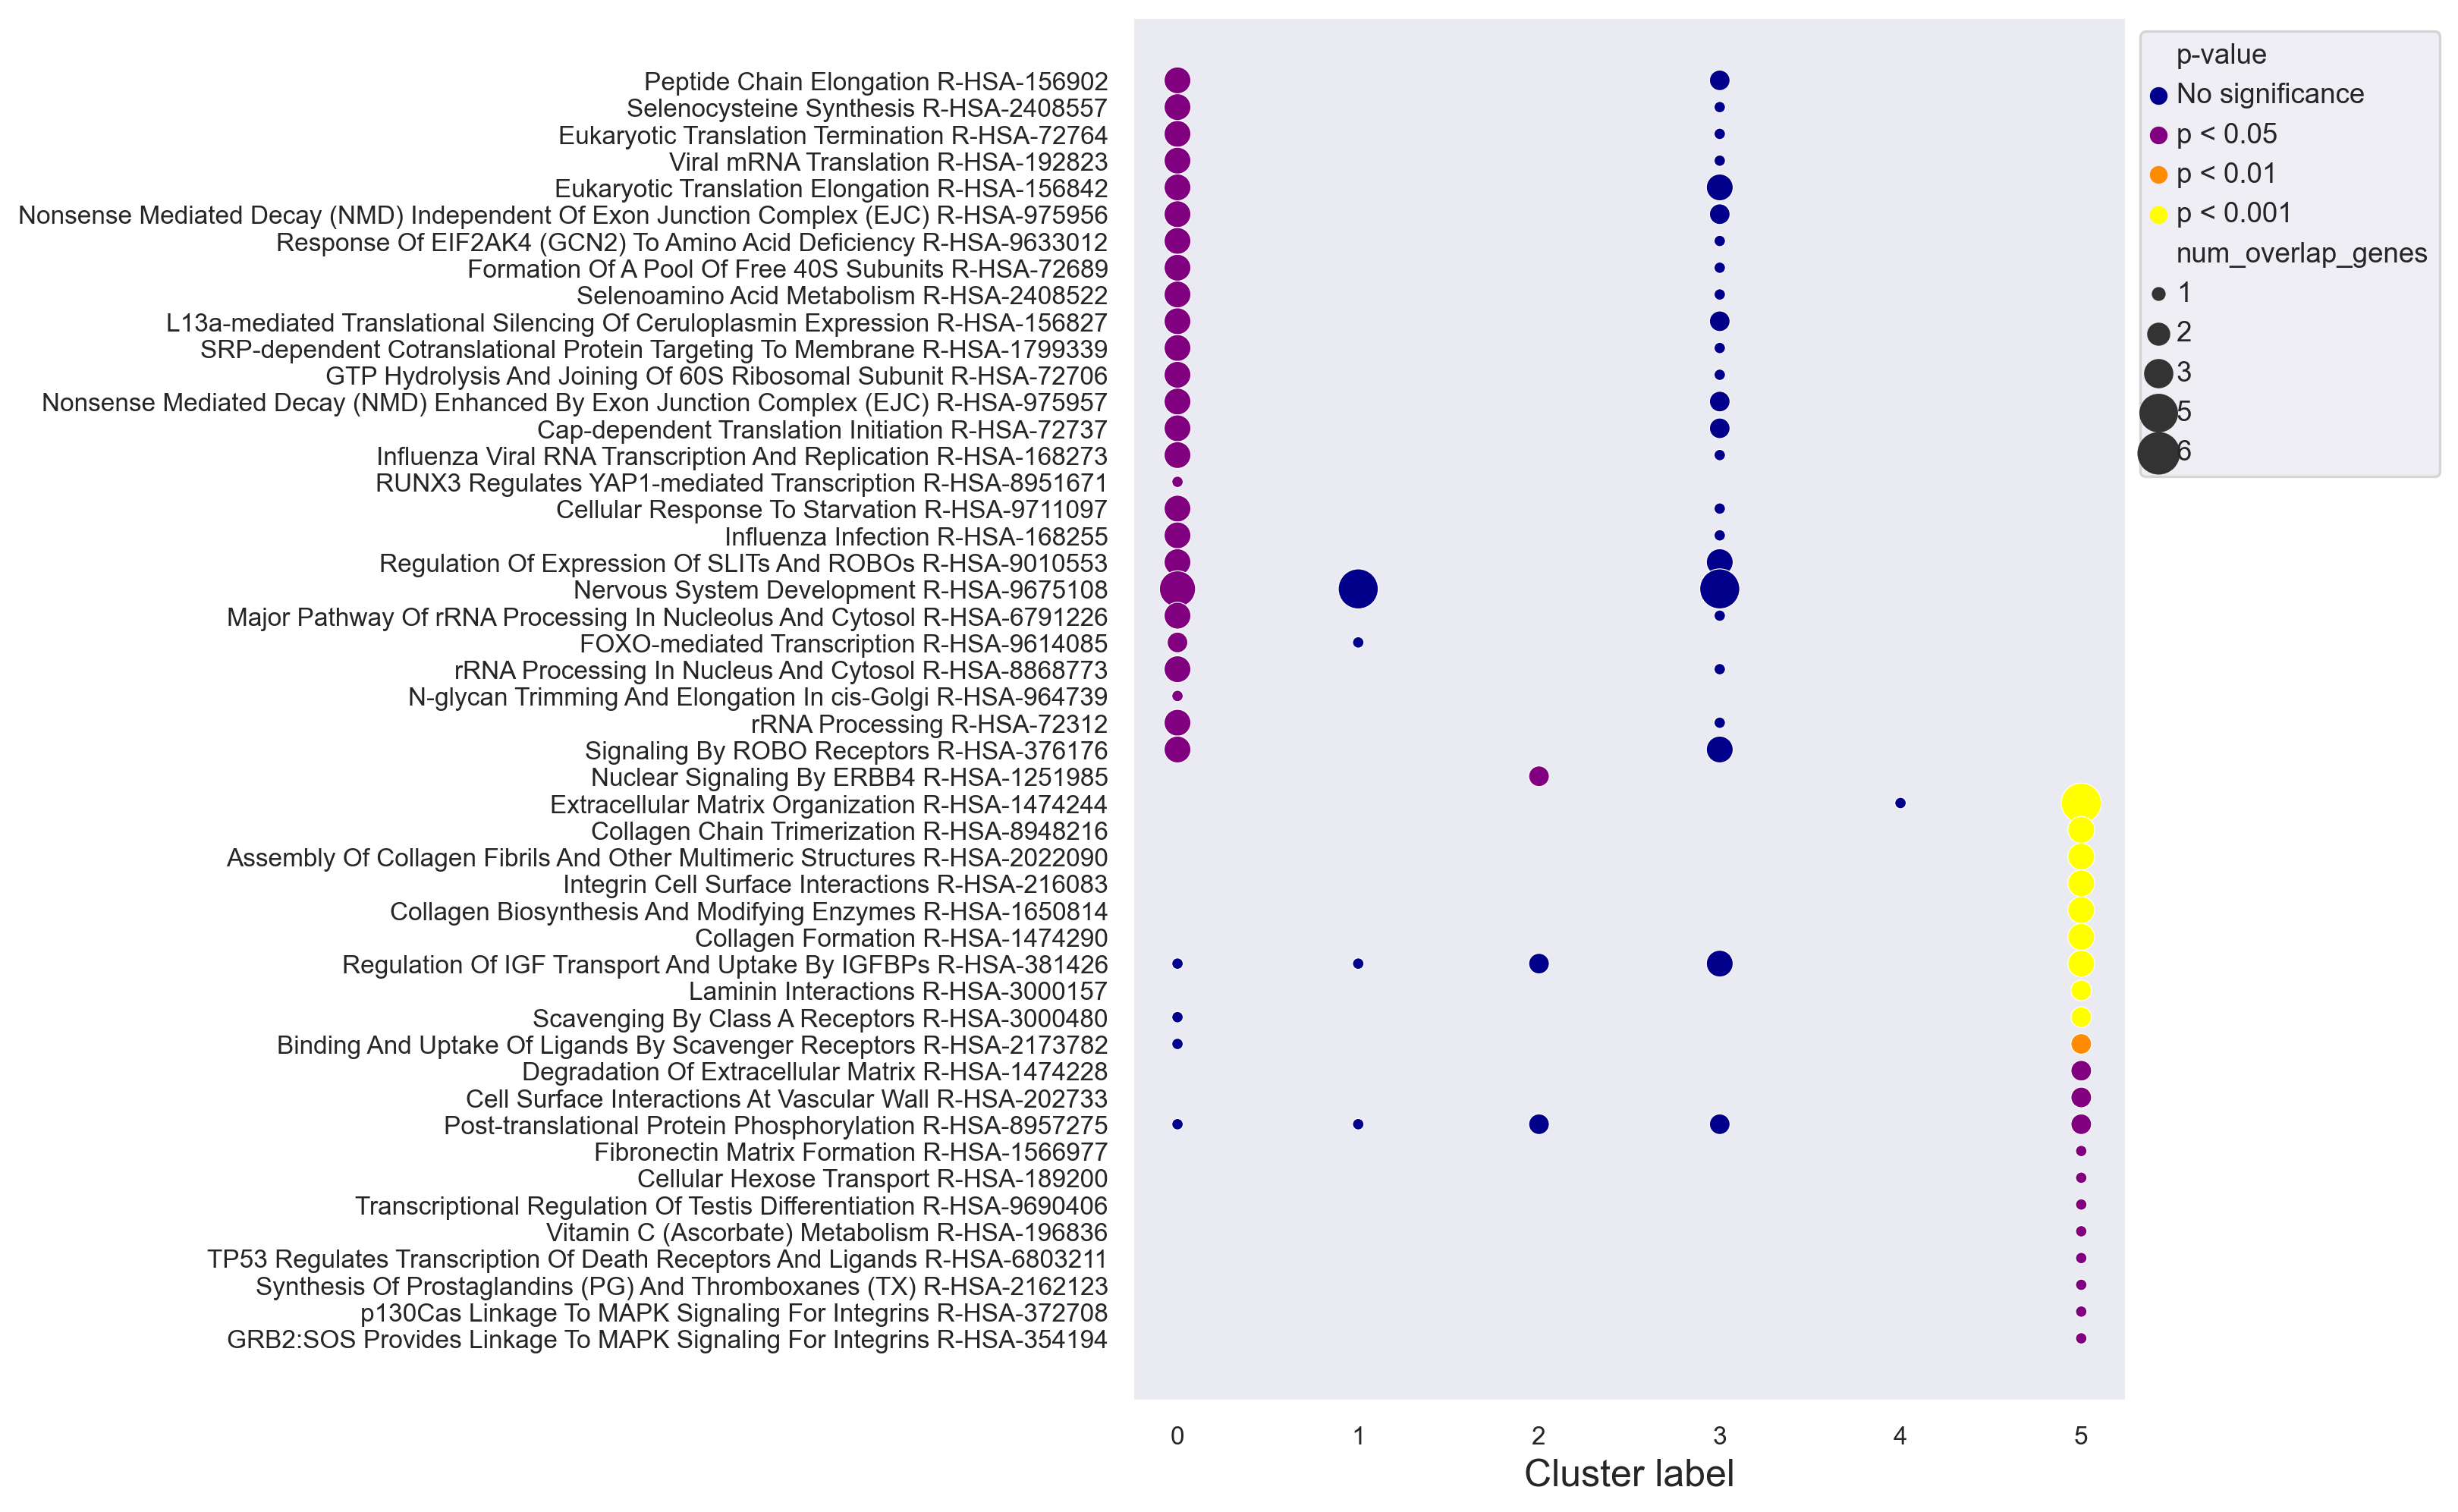

In [115]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## KEGG_2021_Human

In [116]:
GeneCluster.enrich_geneclusters(gene_clust, 'KEGG_2021_Human')

In [117]:
enrich_res = pd.concat([gc.enrichment_res['KEGG_2021_Human'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val    Z-score  \
Term                                                                 
Ribosome                                    1  0.002639  12.257528   
Coronavirus disease                         2  0.005196   9.543158   
TGF-beta signaling pathway                  3  0.011574  13.502959   
Hippo signaling pathway                     4  0.026075   8.641026   
Biosynthesis of unsaturated fatty acids     5  0.053391  19.962963   

                                         Combined score  \
Term                                                      
Ribosome                                      72.777779   
Coronavirus disease                           50.195544   
TGF-beta signaling pathway                    60.209611   
Hippo signaling pathway                       31.511948   
Biosynthesis of unsaturated fatty acids       58.493833   

                                             Overlapping genes  \
Term                                                             
Ribosome                                 [RPL31, RPL12, RPLP2]   
Coronavirus disease                      [RPL31, RPL12, RPLP2]   
TGF-beta signaling pathway                         [ID2, RGMA]   
Hippo signaling pathway                            [ID2, CCN2]   
Biosynthesis of unsaturated fatty acids                 [SCD5]   

                                         Adjusted P-value  Old p-value  \
Term                                                                     
Ribosome                                         0.090932            0   
Coronavirus disease                              0.090932            0   
TGF-beta signaling pathway                       0.135030            0   
Hippo signaling pathway                          0.228155            0   
Biosynthesis of unsaturated fatty acids          0.320941            0   

                                         Old adjusted p-value  \
Term                                                            
Ribosome                                                    0   
Coronavirus disease                                         0   
TGF-beta signaling pathway                                  0   
Hippo signaling pathway                                     0   
Biosynthesis of unsaturated fatty acids                     0   

                                         num_overlap_genes  neg_log10(p_adj)  \
Term                                                                           
Ribosome                                                 3          1.041284   
Coronavirus disease                                      3          1.041284   
TGF-beta signaling pathway                               2          0.869570   
Hippo signaling pathway                                  2          0.641770   
Biosynthesis of unsaturated fatty acids                  1          0.493575   

                                         cluster_label  
Term                                                    
Ribosome                                             0  
Coronavirus disease                                  0  
TGF-beta signaling pathway                           0  
Hippo signaling pathway                              0  
Biosynthesis of unsaturated fatty acids              0

In [118]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

7

In [119]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

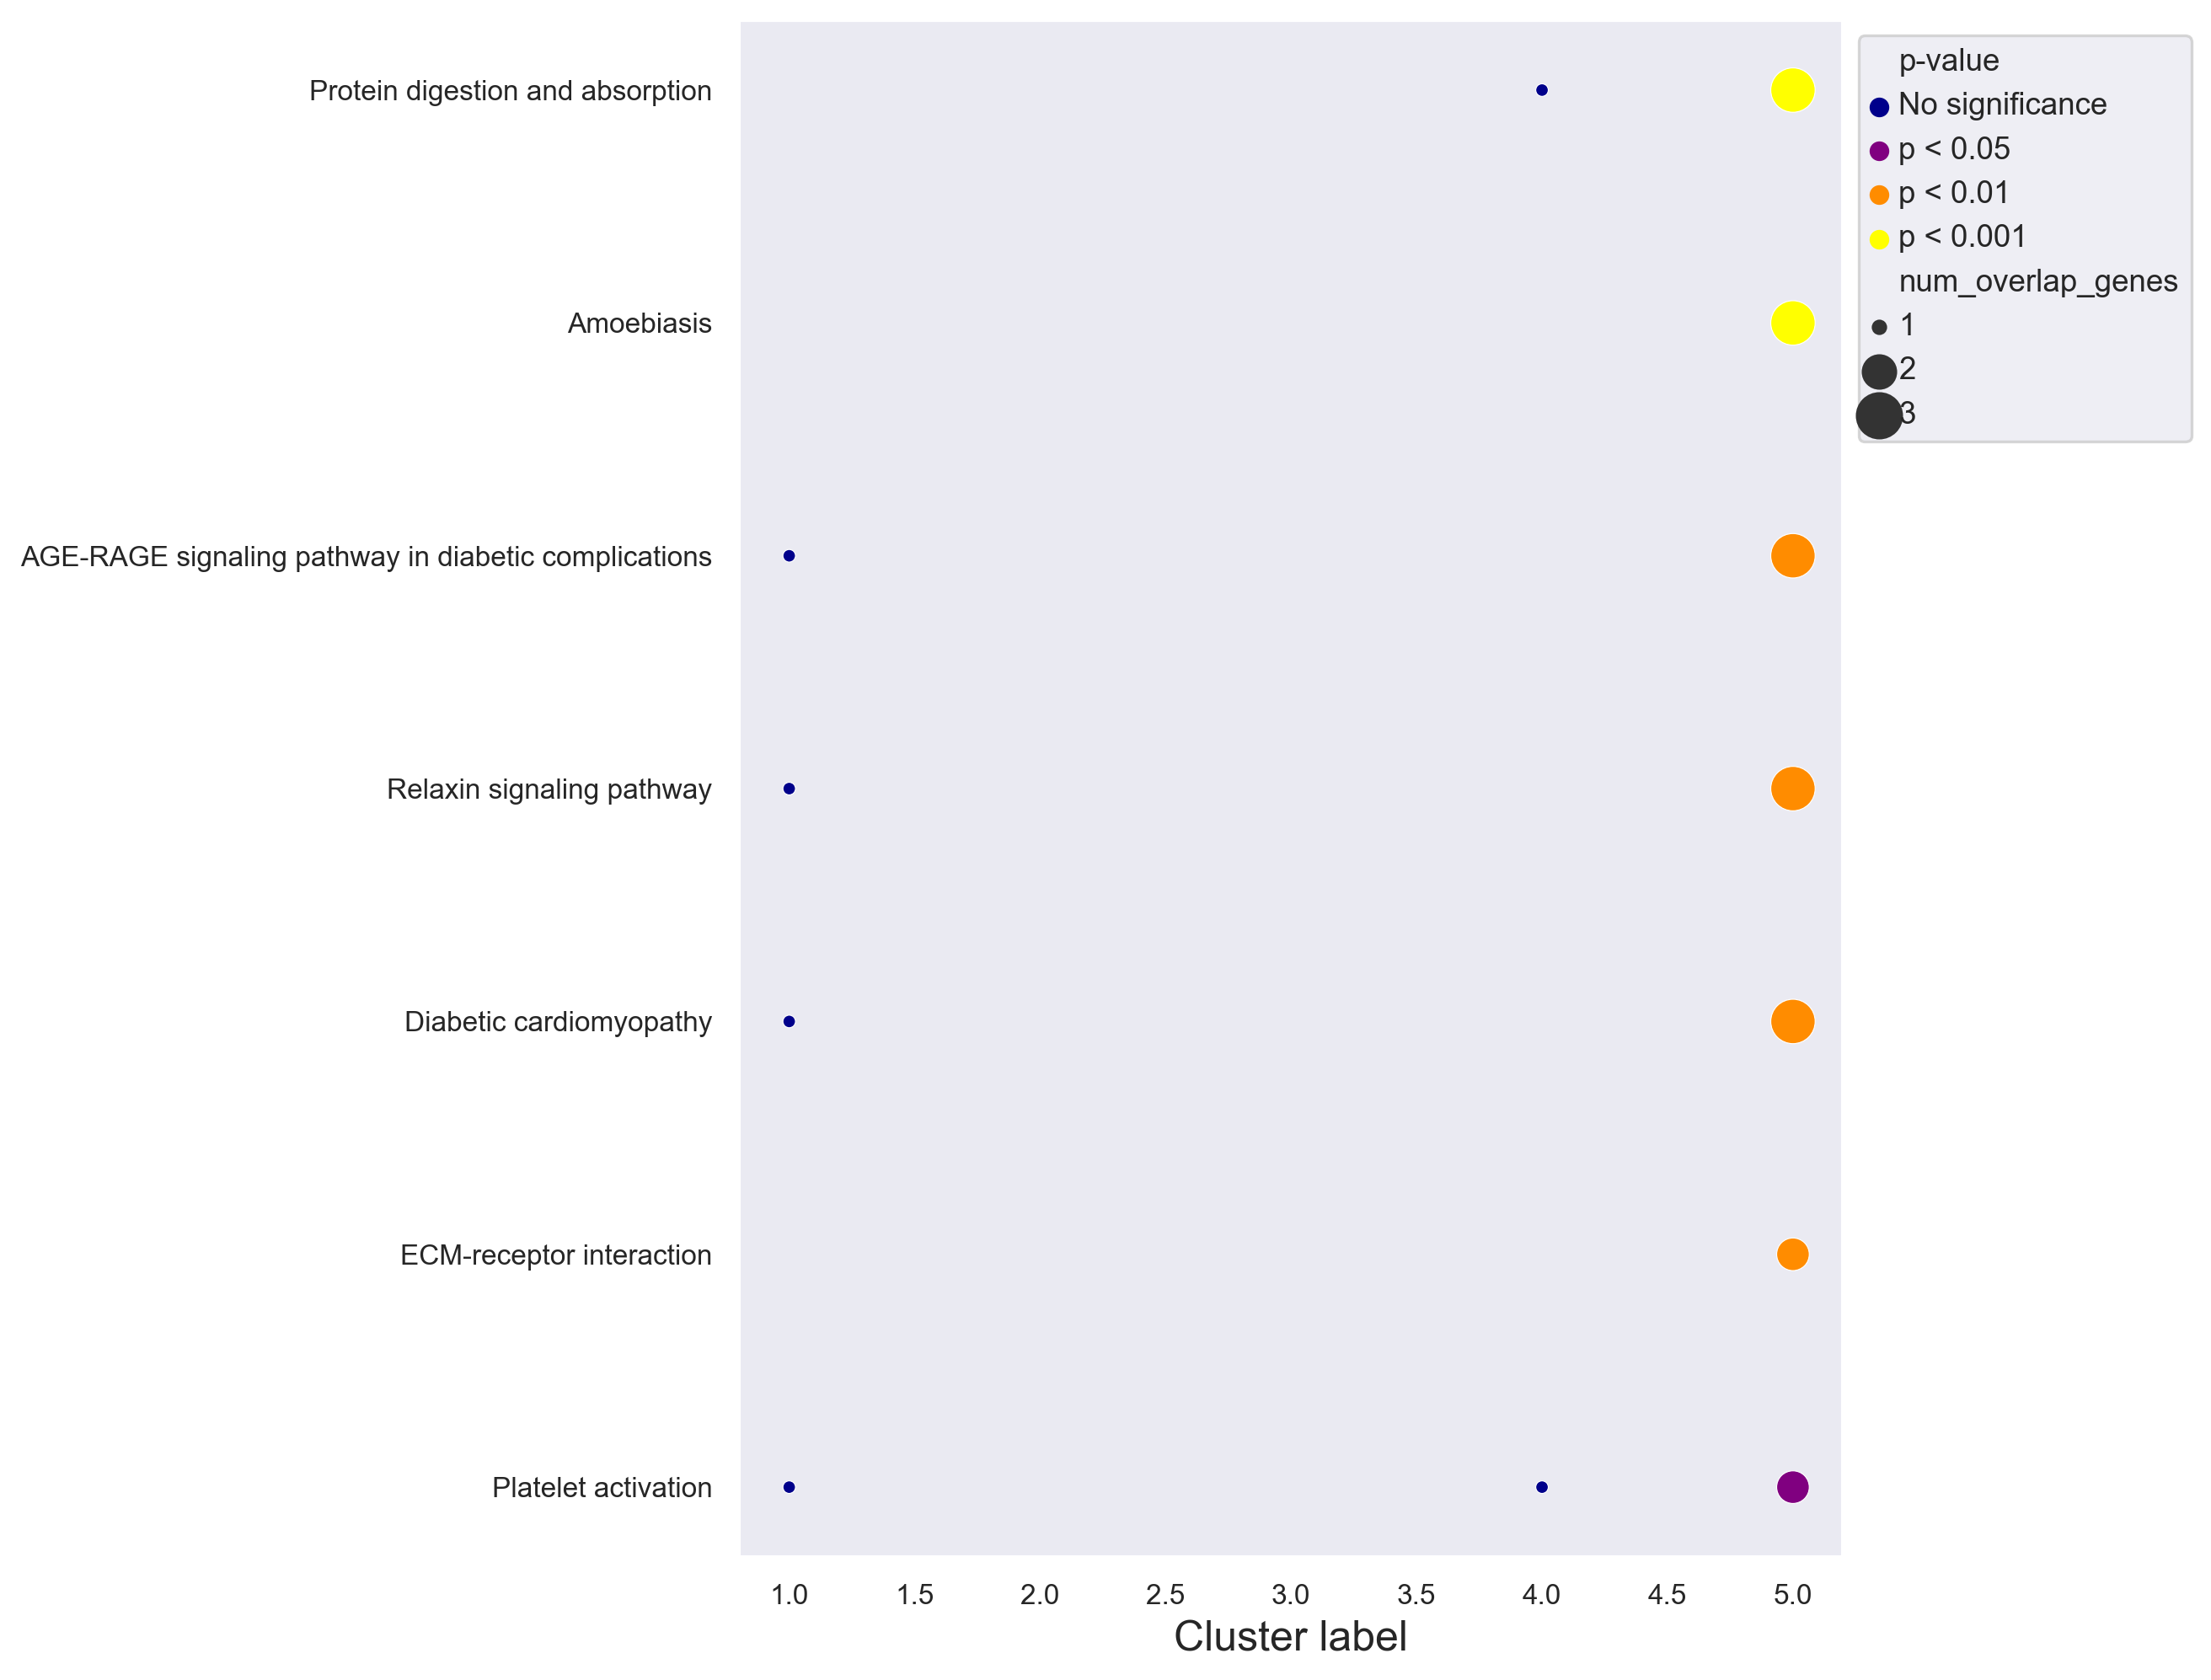

In [120]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))